# COVID-19 Data and Visualizations

### Notes

In [ ]:
# Create vars:
#     Deaths per hospitalized
#     Fraction of cases hospitalized
#     Fraction of cases dead

# Code alternate definitions for active cases and hospitalizations based on different reporting methods so graphs
# for hospitalizations are complete

### Import Statements

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from operator import itemgetter
from matplotlib.pyplot import figure

### Load Data

In [4]:
#########################################################
##  SOURCE: THE COVID TRACKING PROJECT                 ##
##  https://covidtracking.com/api/v1/states/daily.csv  ## 
#########################################################

In [5]:
df = pd.read_csv('state_daily.csv', parse_dates=['date'])
df_us = pd.read_csv('us_daily.csv', parse_dates=['date'])
state_pops = pd.read_csv('state_pops.csv', header=None).set_index(2)

### Drop Deprecated Variables

In [6]:
df = df.drop(['checkTimeEt','commercialScore','dateChecked','dateModified','deathIncrease','grade',
    'hospitalized','hospitalizedIncrease','negativeIncrease','negativeRegularScore',
    'negativeScore','posNeg','positiveIncrease','positiveScore','score','total','totalTestResultsIncrease'],axis=1)

### Create Dictionary of DataFrames, One for Each State

In [7]:
states = df.state.unique()

dfs = {}

dfs['USA'] = df_us.set_index('date')

for state in states:
    key = state
    value = df[df.state==state].set_index('date').drop('state', axis=1)
    dfs[key] = value

# Variable Construction

### Daily and Cumulative Variables

In [8]:
for state in dfs.keys():

# New Positives
    dfs[state]['new_pos'] = dfs[state]['positive'] - dfs[state]['positive'].shift(-1)

# New Negatives
    dfs[state]['new_neg'] = dfs[state]['negative'] - dfs[state]['negative'].shift(-1)

# New Tests Total
    dfs[state]['new_tests'] = dfs[state]['new_pos'] + dfs[state]['new_neg']
    
# Daily percent positive
    dfs[state]['daily_pct_pos'] = 100 * dfs[state]['new_pos'] / dfs[state]['new_tests']

# Total Tests to Date
    dfs[state]['total_tests'] = dfs[state]['positive'] + dfs[state]['negative']
    
# New Hospitalizations
    dfs[state]['new_hosp'] = dfs[state]['hospitalizedCumulative'] - dfs[state]['hospitalizedCumulative'].shift(-1)

# New Deaths
    dfs[state]['new_deaths'] = dfs[state]['death'] - dfs[state]['death'].shift(-1)

# max(New Positives)
    dfs[state]['peak_rate'] = np.max(dfs[state]['new_pos'])
    
# Date of max(New Positives)
    dfs[state]['peak_date'] = dfs[state].index[dfs[state]['new_pos']==dfs[state]['peak_rate']][0]
    
# Active cases
    dfs[state]['active'] = dfs[state]['positive'] - dfs[state]['death'] - dfs[state]['recovered']

# Daily growth factor relative to positive tests
    dfs[state]['daily_growth_factor_a'] = dfs[state]['new_pos'] / dfs[state]['positive']
    
# Daily growth factor relative to ('Active' = pos-deaths-recovered) 
    dfs[state]['daily_growth_factor_b'] = dfs[state]['new_pos'] / dfs[state]['active']

### PER CAPITA Daily and Cumulative Variables

In [9]:
for state in dfs.keys():

# New Positives
    dfs[state]['new_pos_pc'] = dfs[state]['new_pos']  / state_pops.loc[state][1]

# New Negatives
    dfs[state]['new_neg_pc'] = dfs[state]['new_neg'] / state_pops.loc[state][1]

# New Tests Total
    dfs[state]['new_tests_pc'] = dfs[state]['new_tests'] / state_pops.loc[state][1]

# Total Tests to Date
    dfs[state]['total_tests_pc'] = dfs[state]['total_tests'] / state_pops.loc[state][1]
    
# New Hospitalizations
    dfs[state]['new_hosp_pc'] = dfs[state]['new_hosp'] / state_pops.loc[state][1]

# New Deaths
    dfs[state]['new_deaths_pc'] = dfs[state]['new_deaths'] / state_pops.loc[state][1]
    
# Active cases
    dfs[state]['active'] = dfs[state]['positive'] - dfs[state]['death'] - dfs[state]['recovered']

### SET SIZE OF ROLLING WINDOW

In [10]:
######################################################
######################################################     
# Set size of rolling window
window = 7
######################################################     
######################################################  

### Rolling Average Variables

In [29]:
for state in dfs.keys():
    
# ROLLING AVERAGES OF:

# new cases
    dfs[state]['new_cases_rolling'] = dfs[state]['new_pos'].rolling(window=window).mean()

# hospitalizations
    dfs[state]['new_hosp_rolling'] = dfs[state]['new_hosp'].rolling(window=window).mean()

# new deaths
    dfs[state]['new_deaths_rolling'] = dfs[state]['new_deaths'].rolling(window=window).mean()

# daily percent positive tests       
    dfs[state]['daily_pct_pos_rolling'] = 100 * (dfs[state]['new_pos'] / dfs[state]['new_tests']).rolling(window=window).mean()

### PER CAPITA Rolling Average Variables

In [18]:
for state in dfs.keys():     
    
# Rolling averages of new cases, new hospitalizations, new deaths
    dfs[state]['new_cases_rolling_pc'] = dfs[state]['new_pos'].rolling(window=window).mean() / state_pops.loc[state][1]
    dfs[state]['new_hosp_rolling_pc'] = dfs[state]['new_hosp'].rolling(window=window).mean() / state_pops.loc[state][1]
    dfs[state]['new_deaths_rolling_pc'] = dfs[state]['new_deaths'].rolling(window=window).mean() / state_pops.loc[state][1]

# Visualizations

### Rolling Average of Daily Percentage of Tests with Positive Result

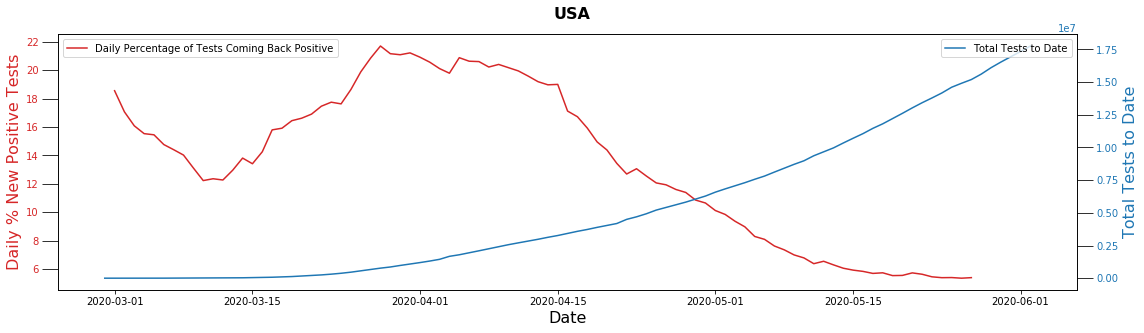

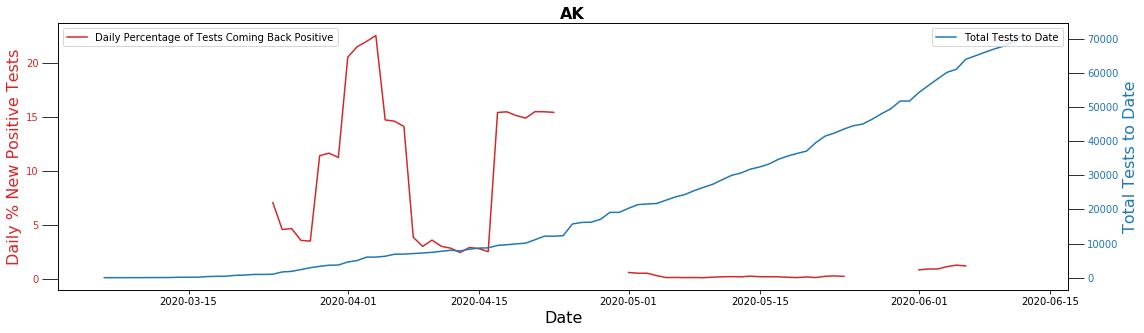

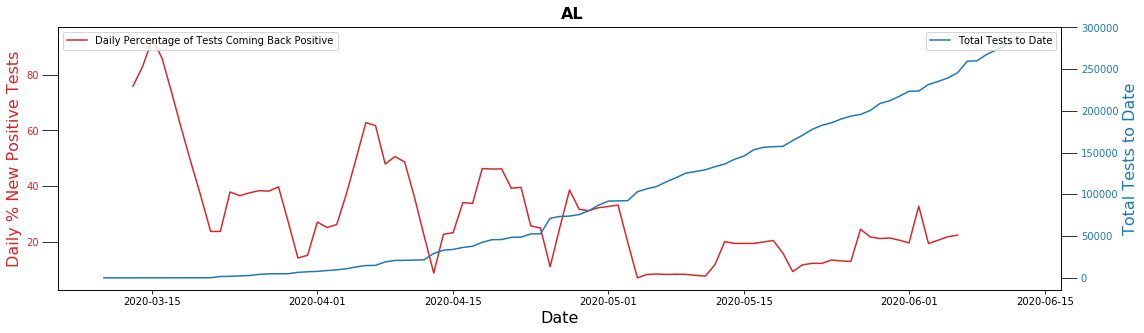

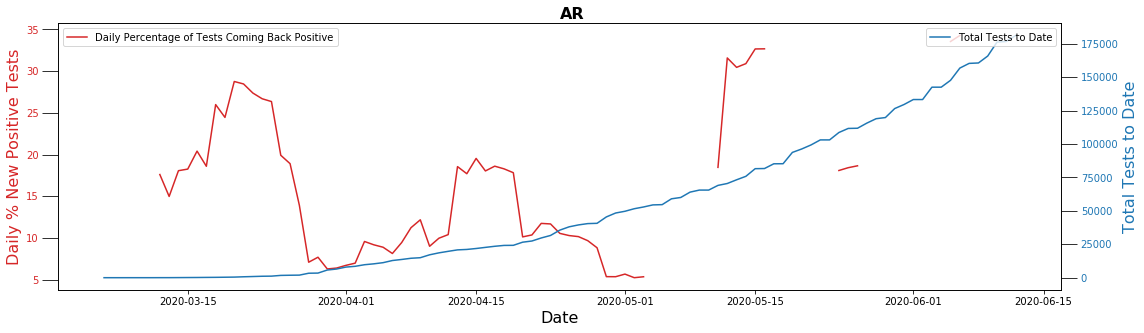

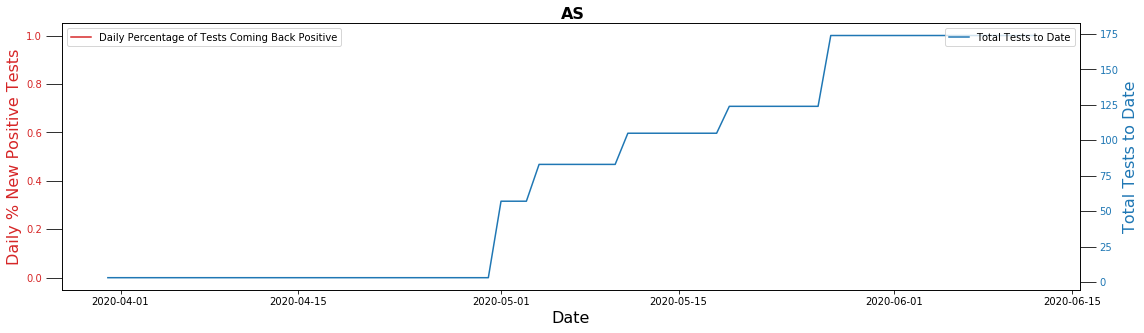

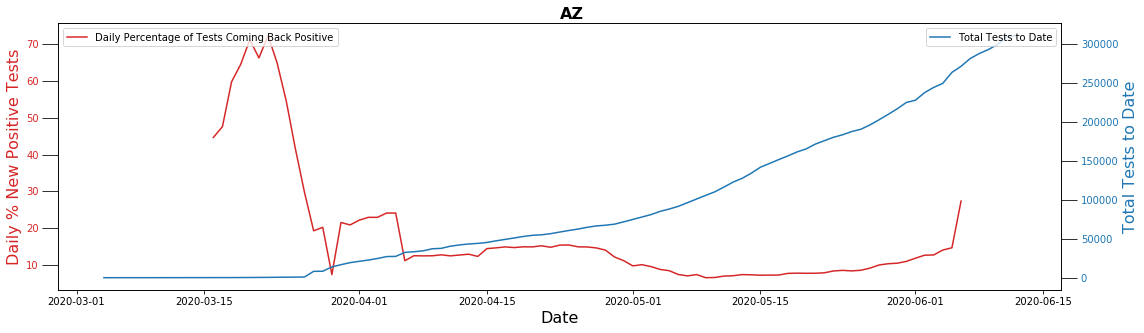

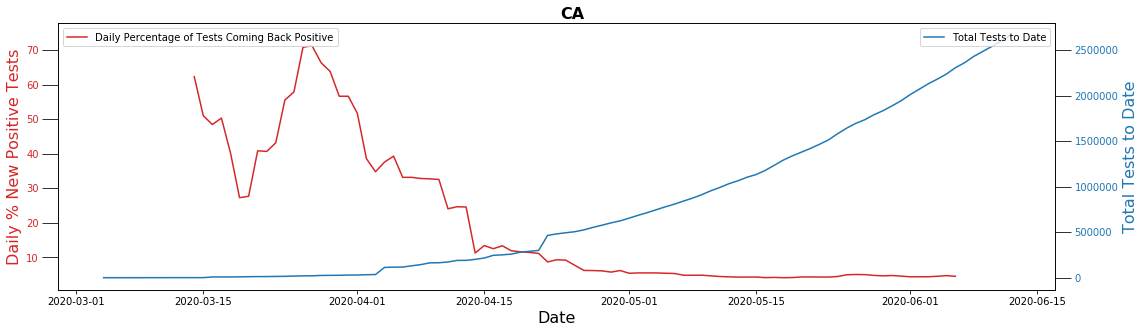

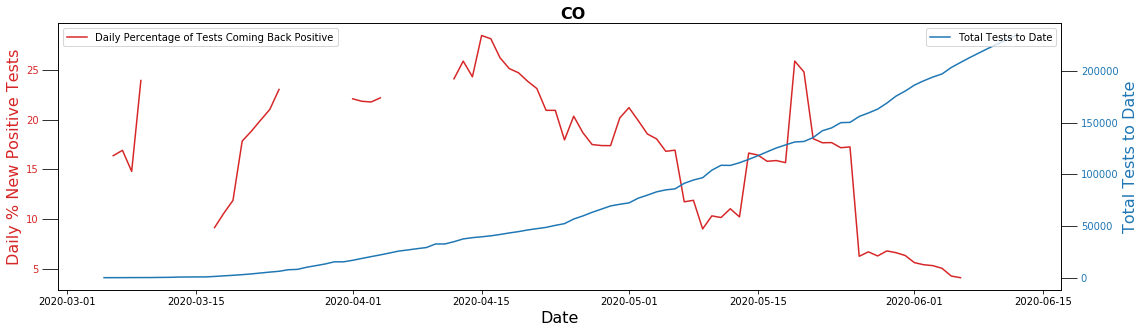

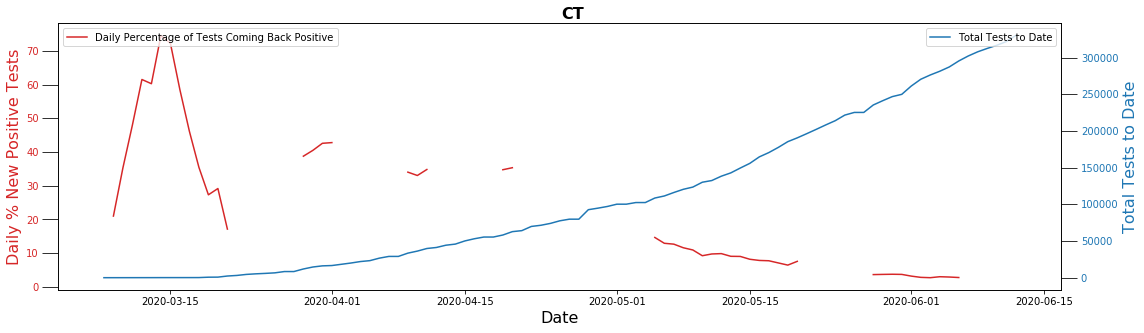

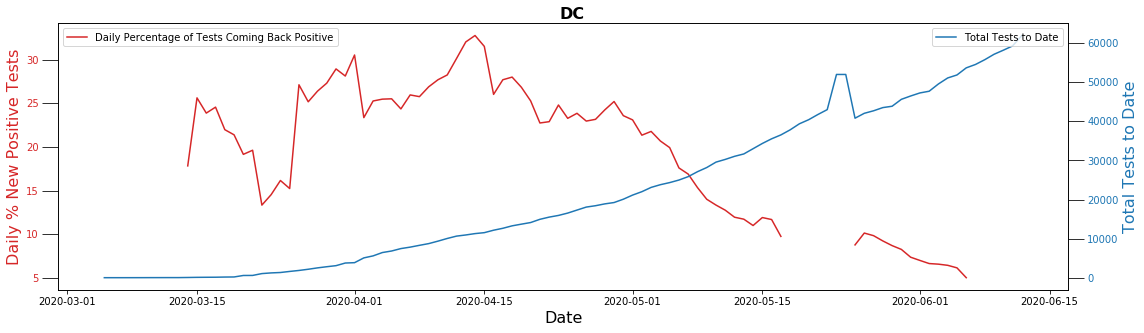

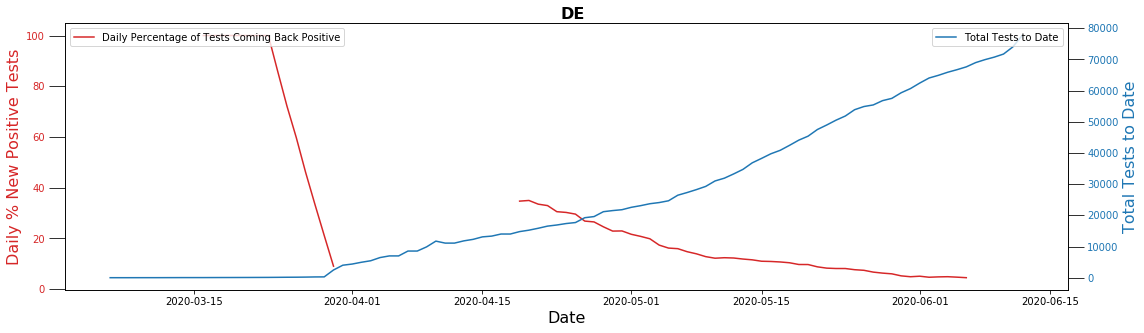

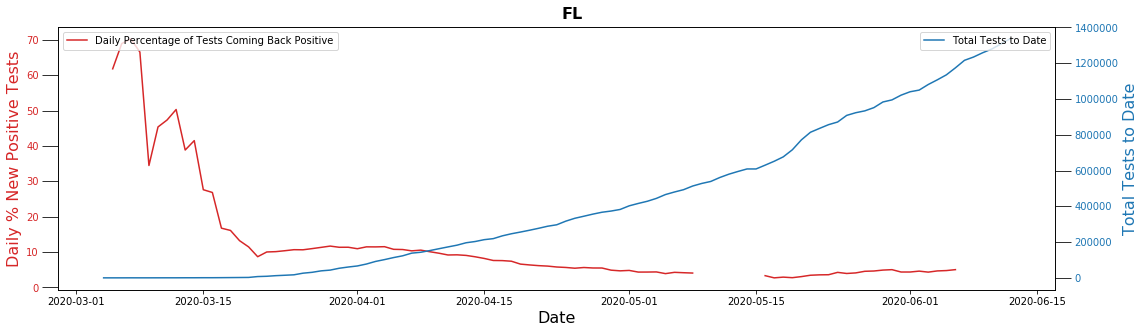

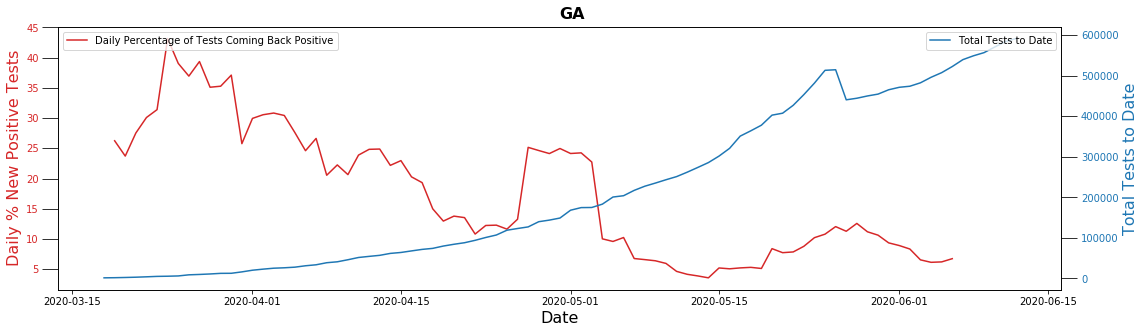

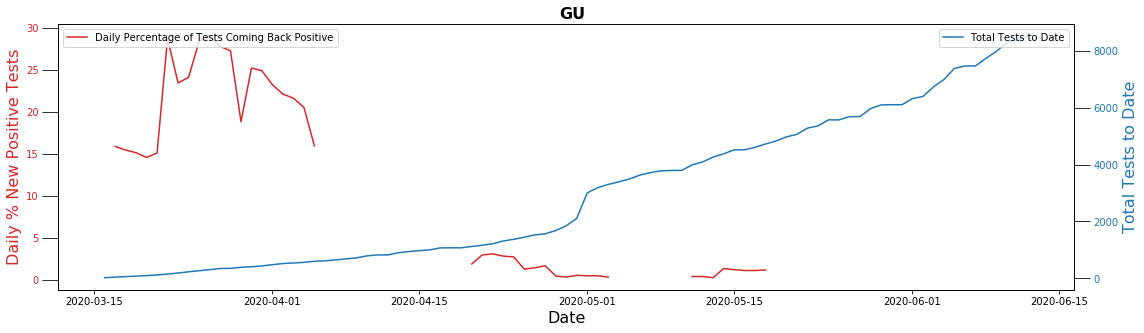

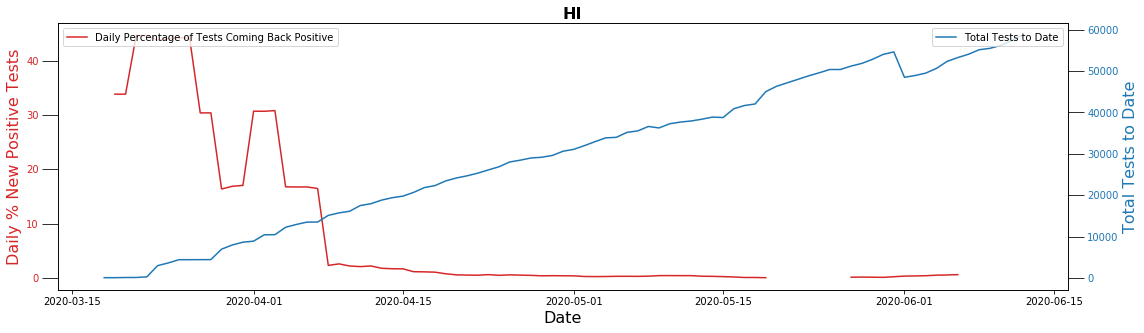

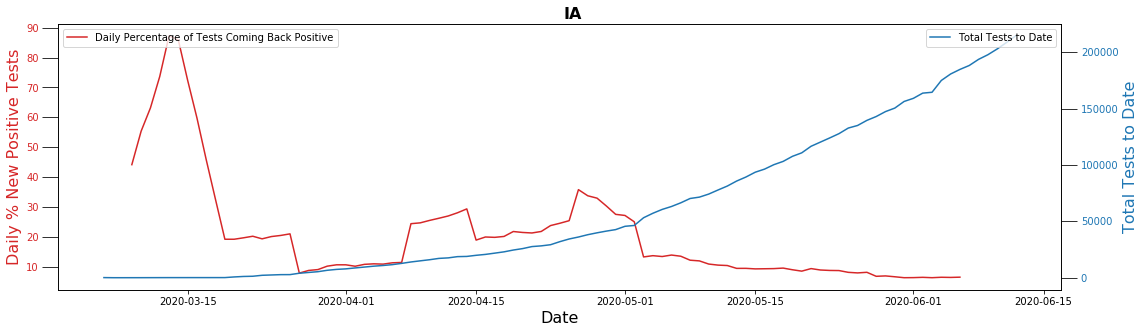

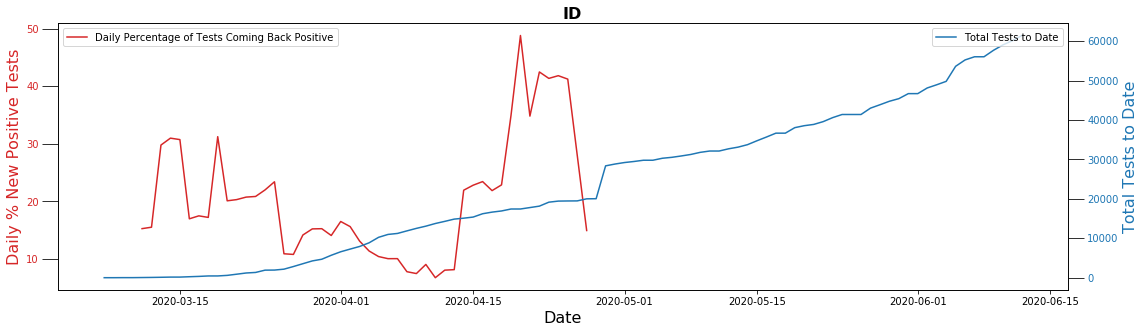

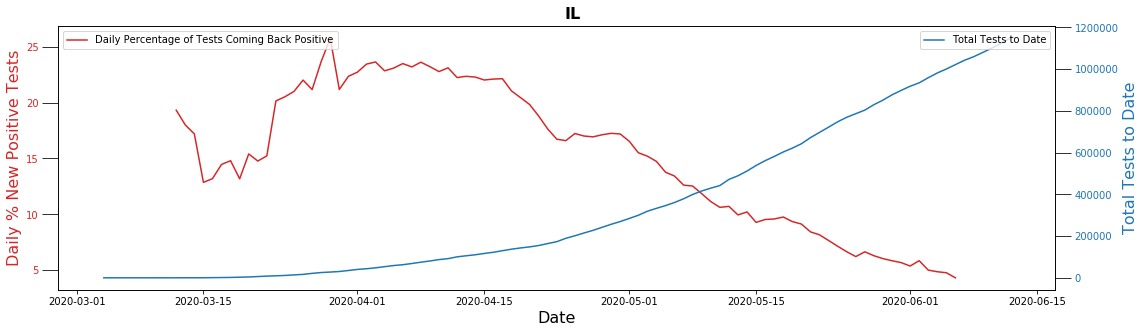

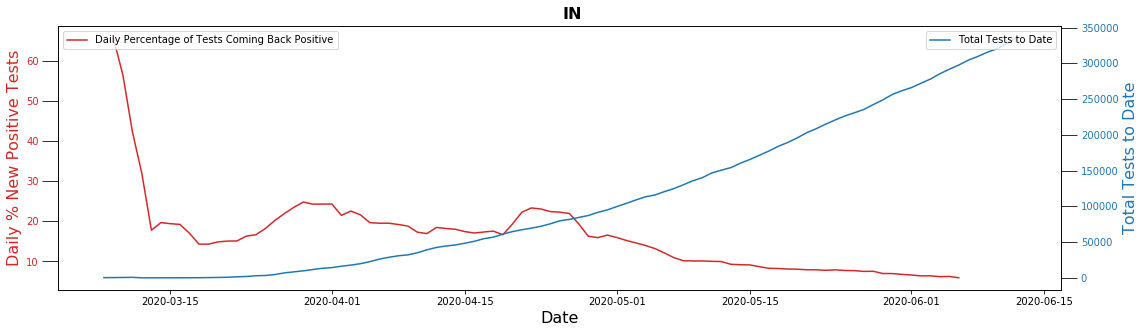

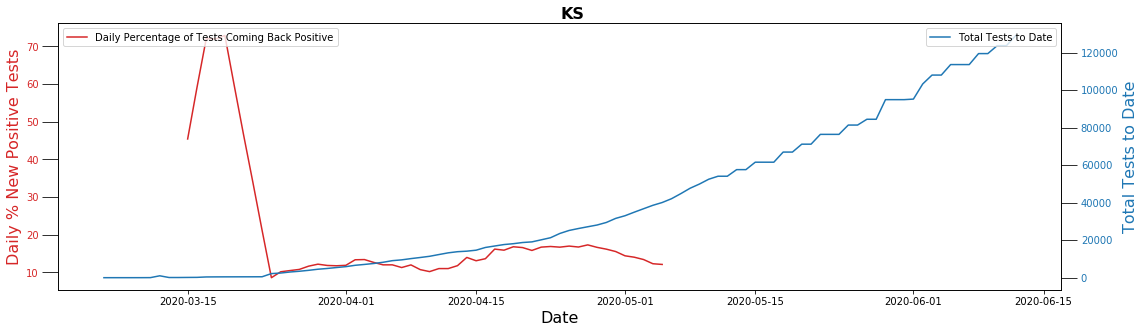

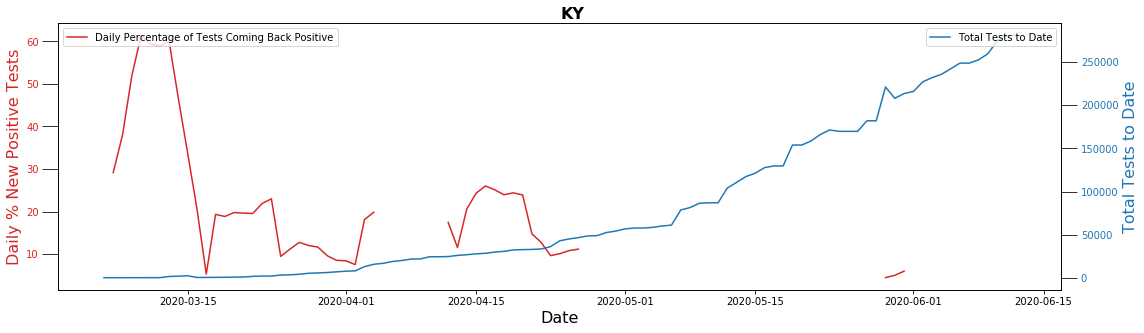

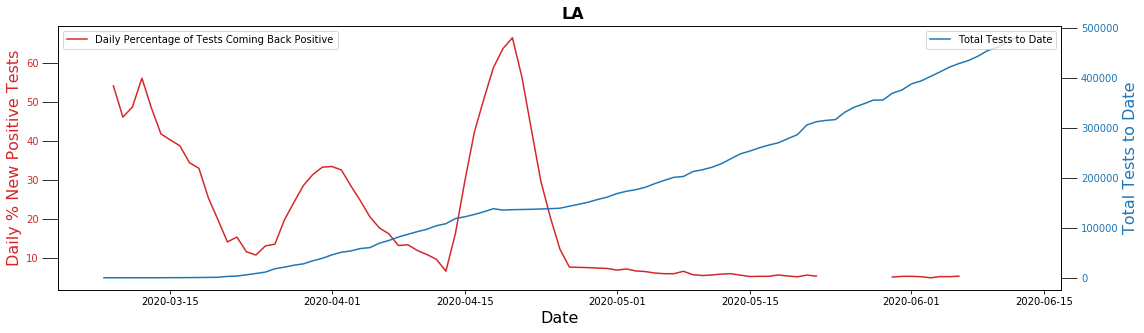

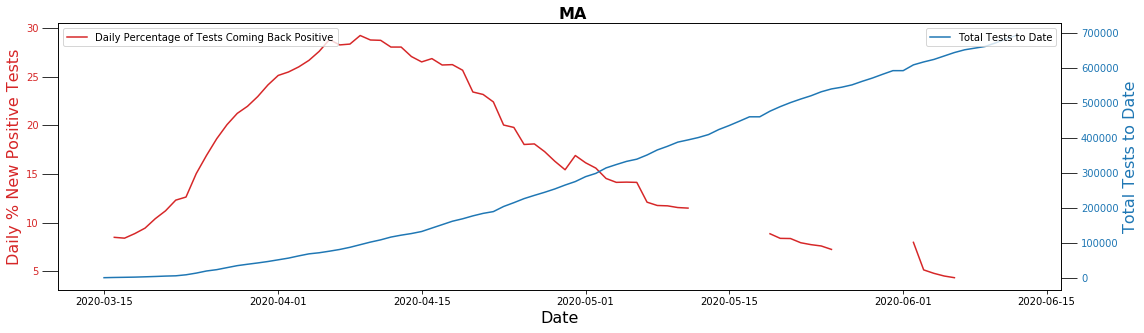

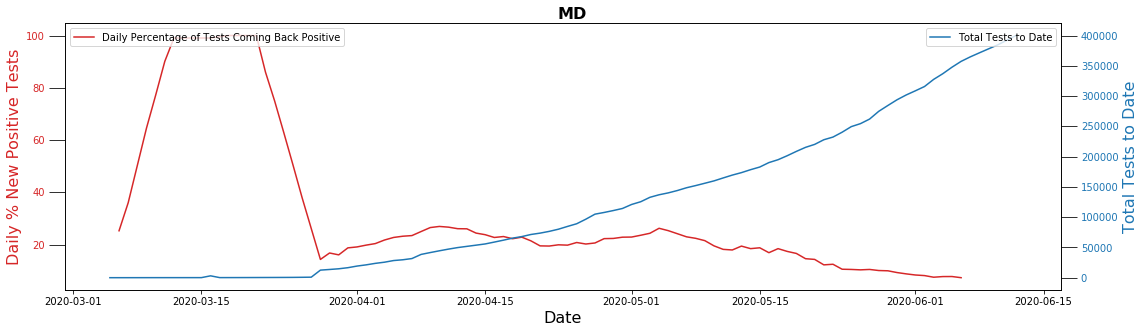

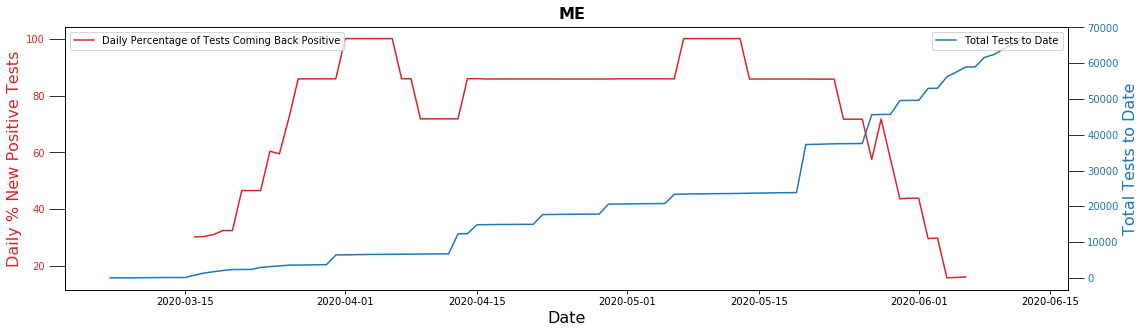

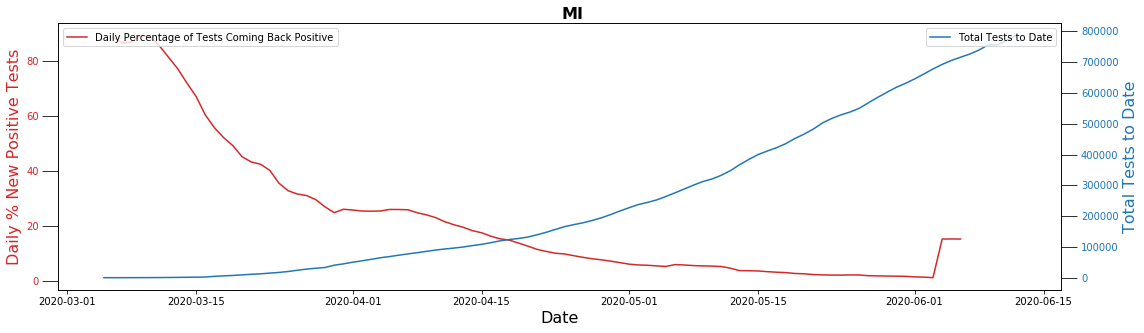

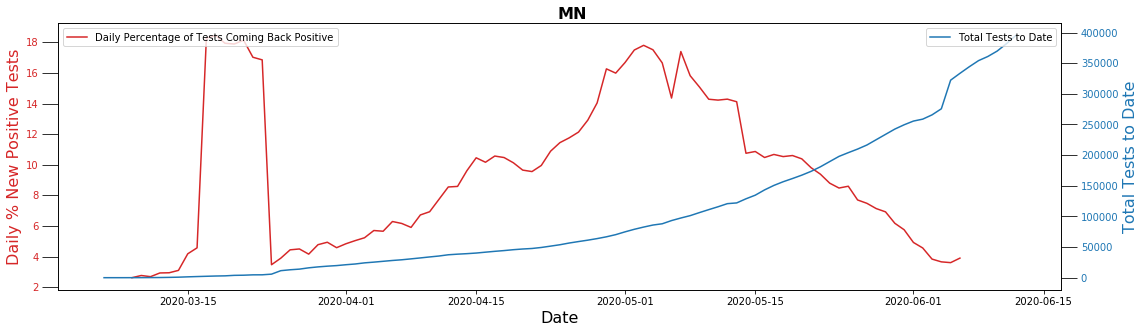

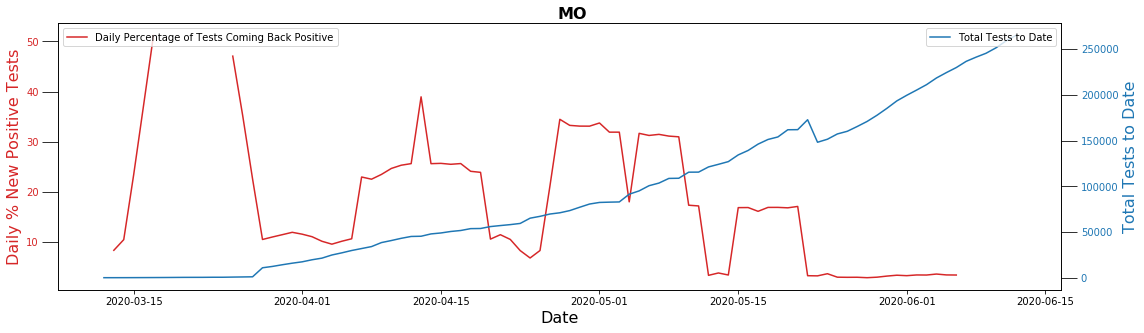

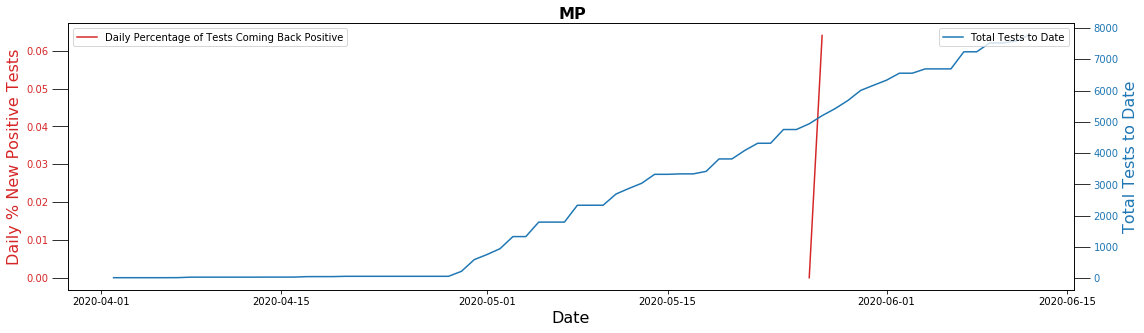

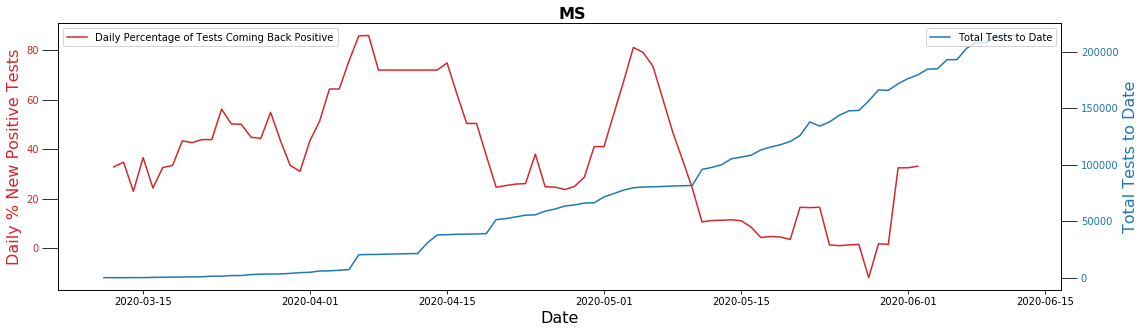

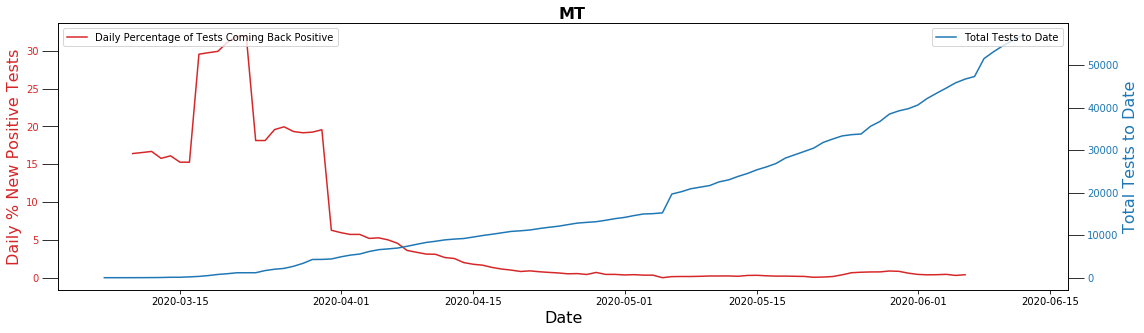

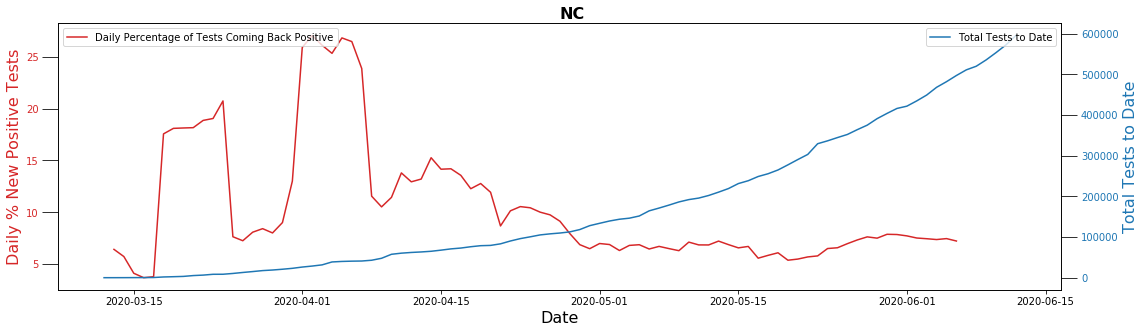

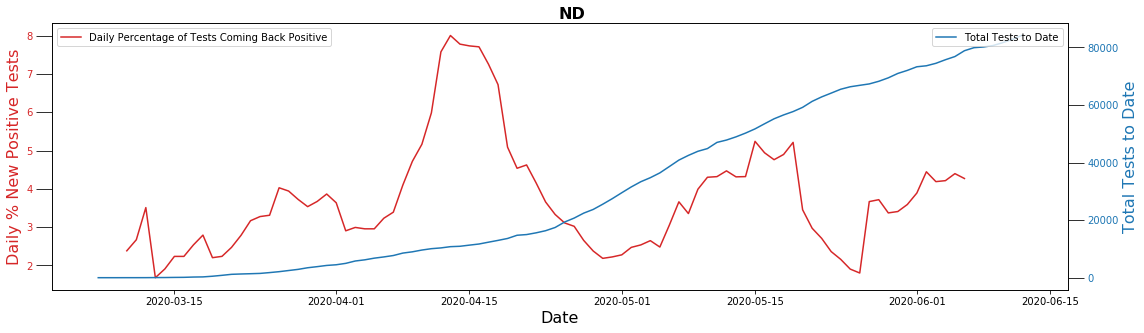

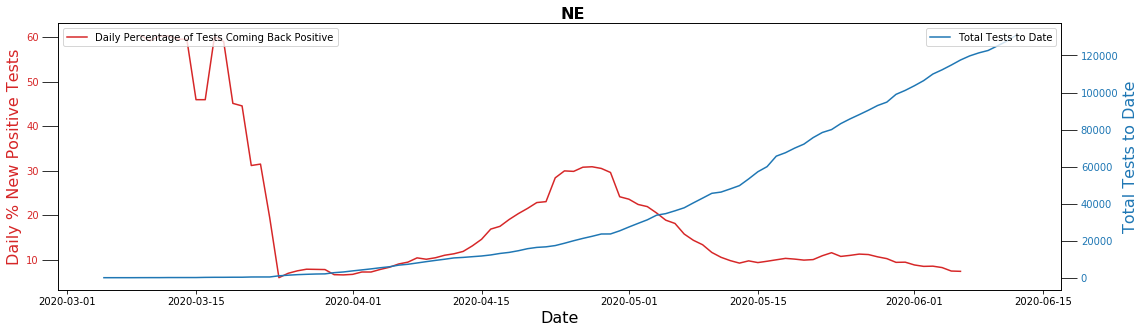

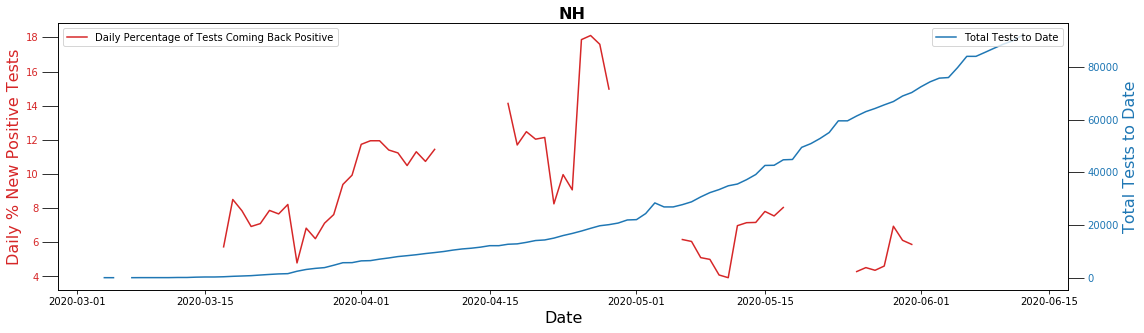

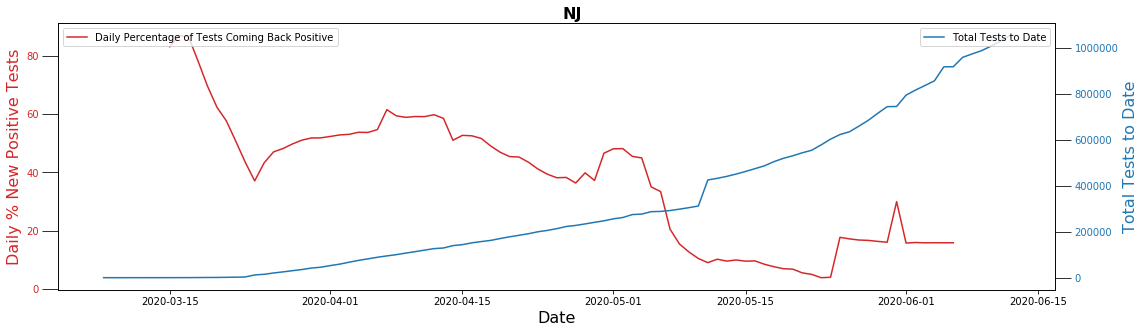

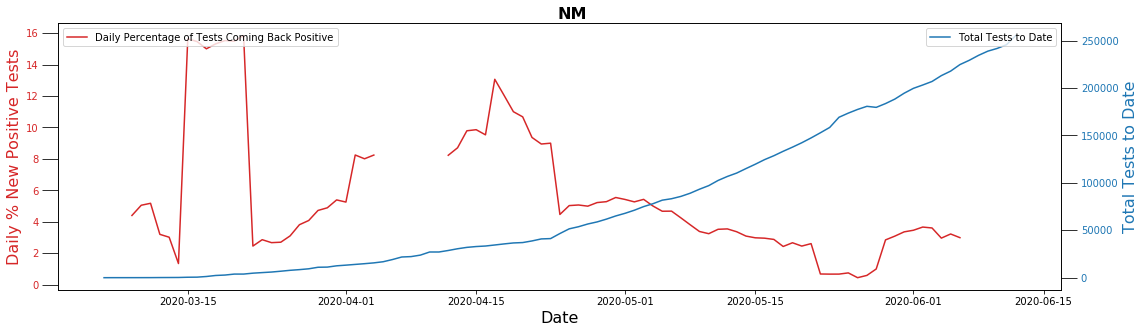

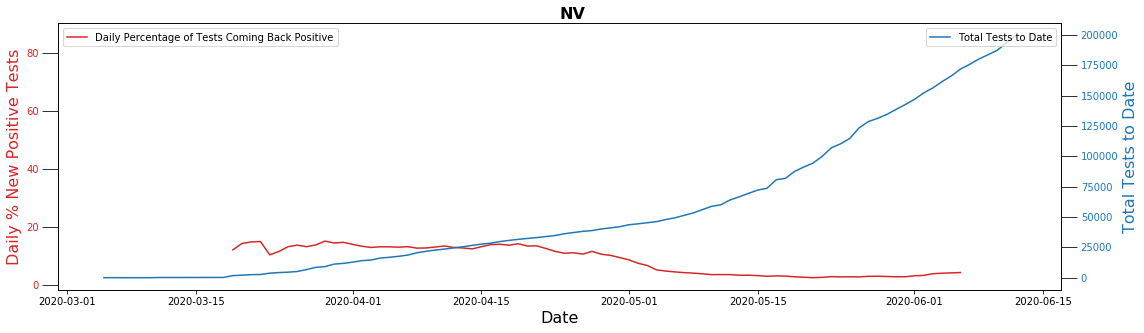

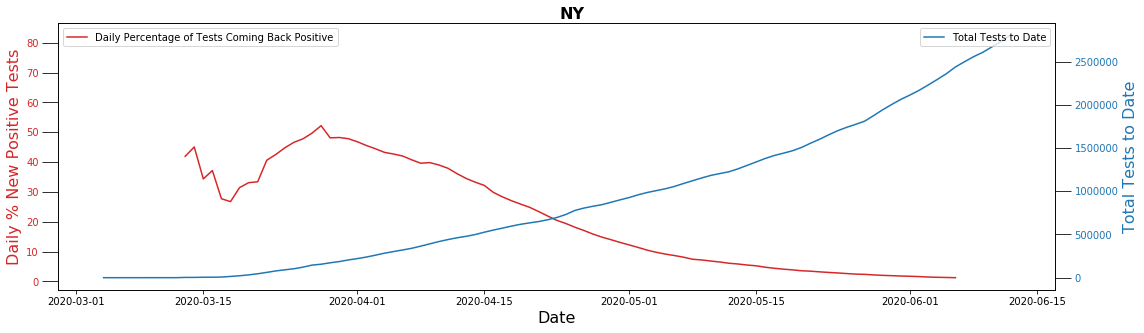

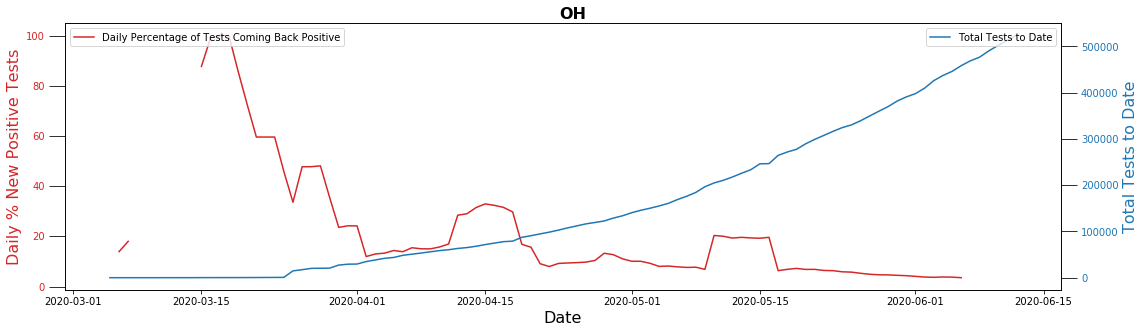

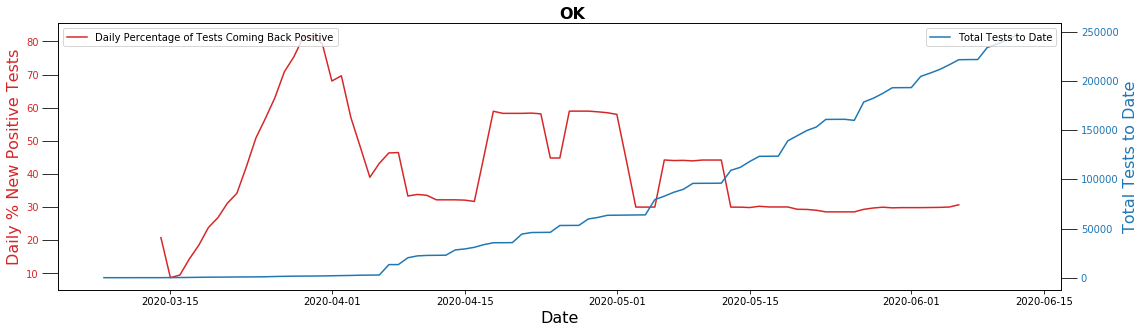

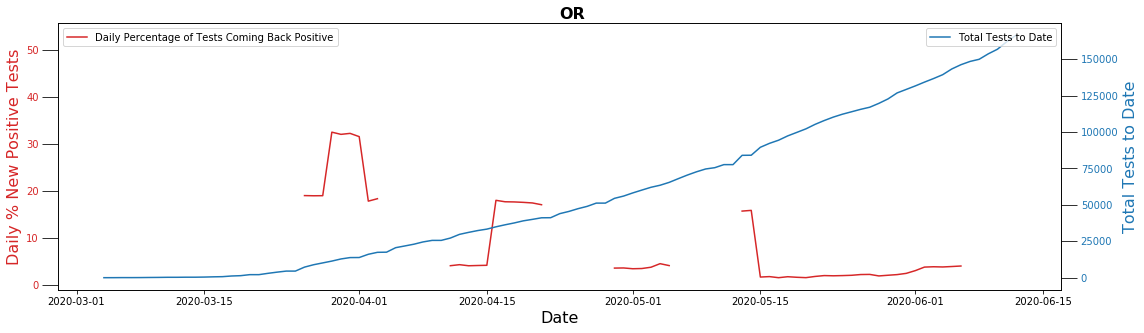

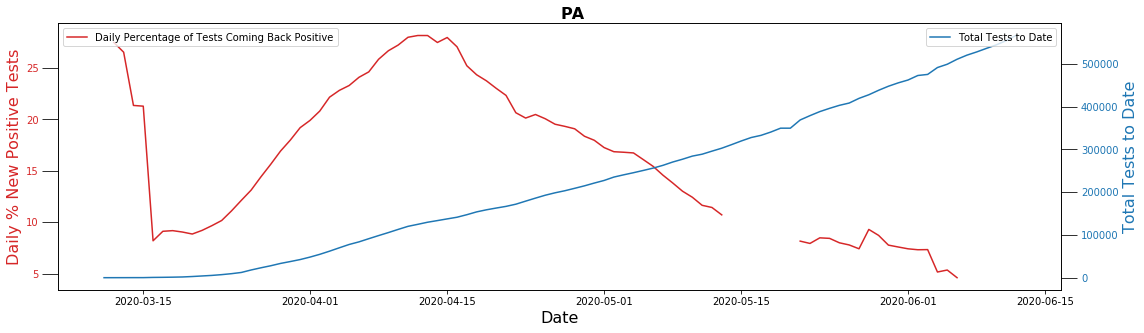

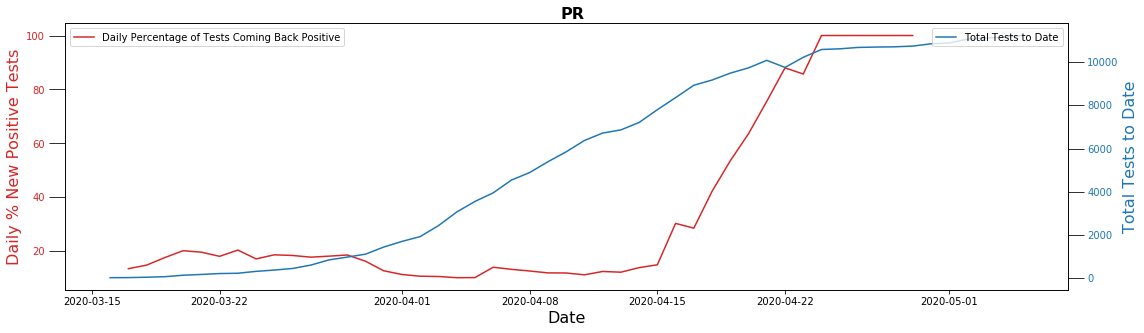

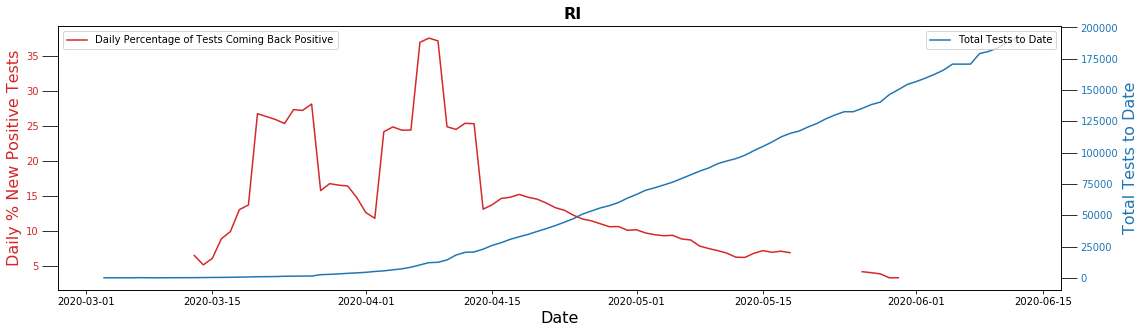

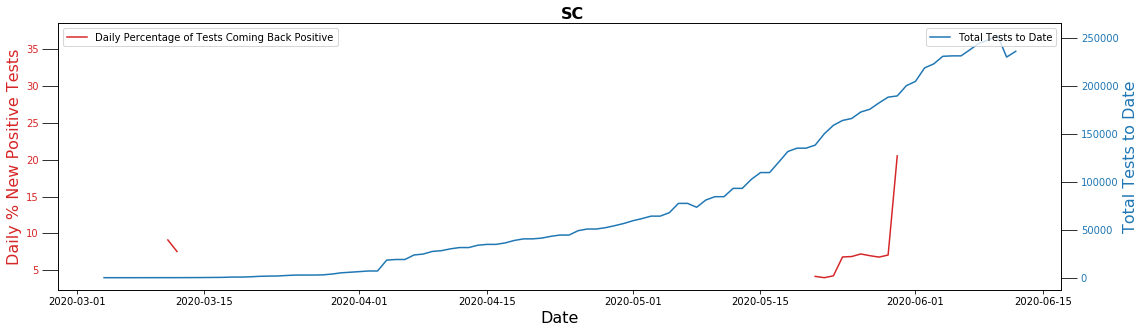

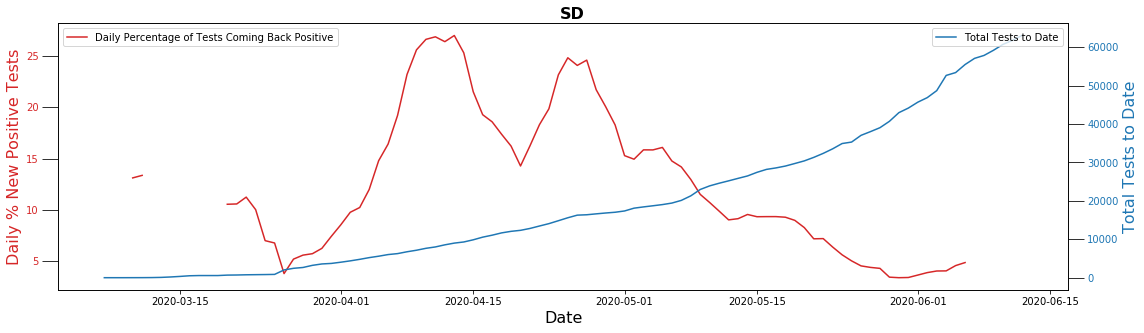

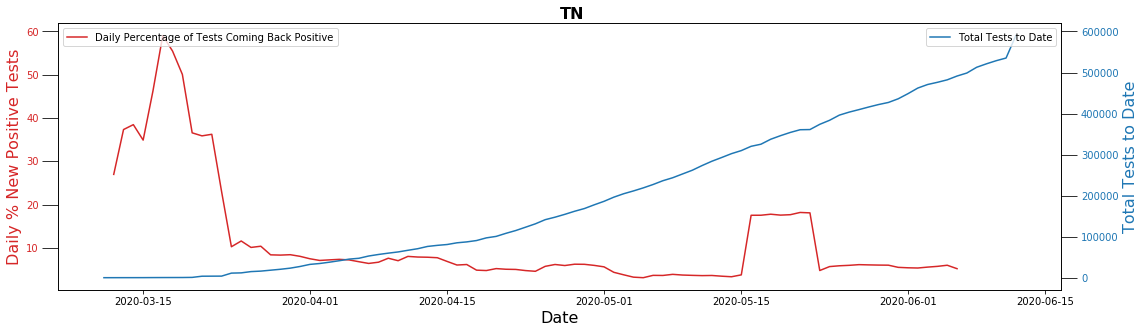

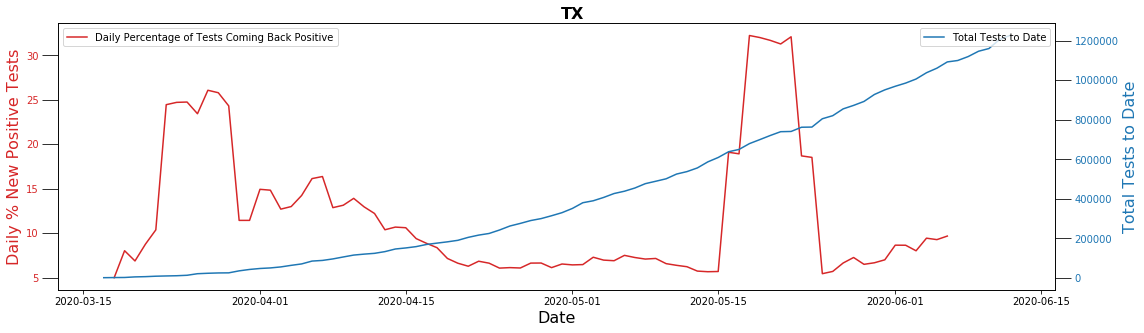

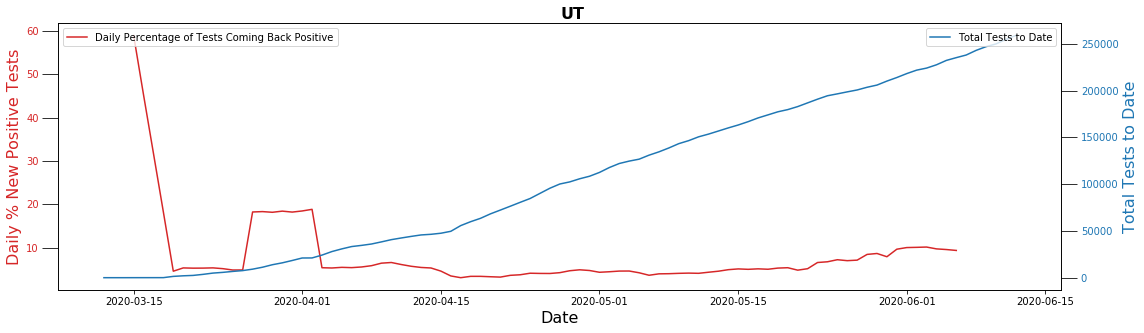

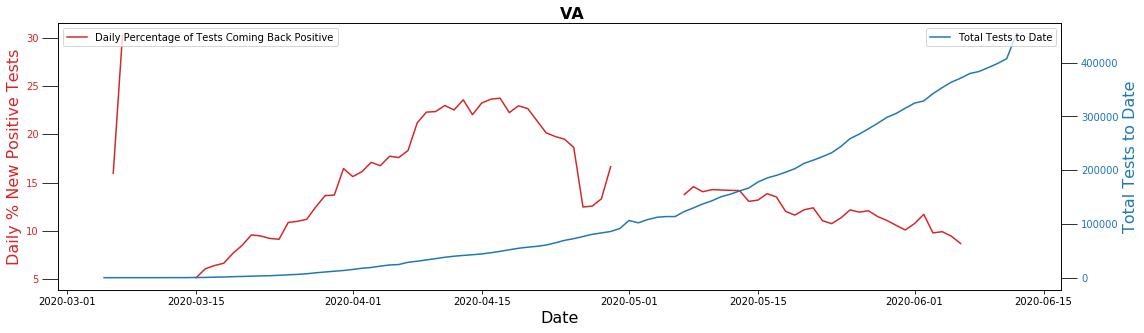

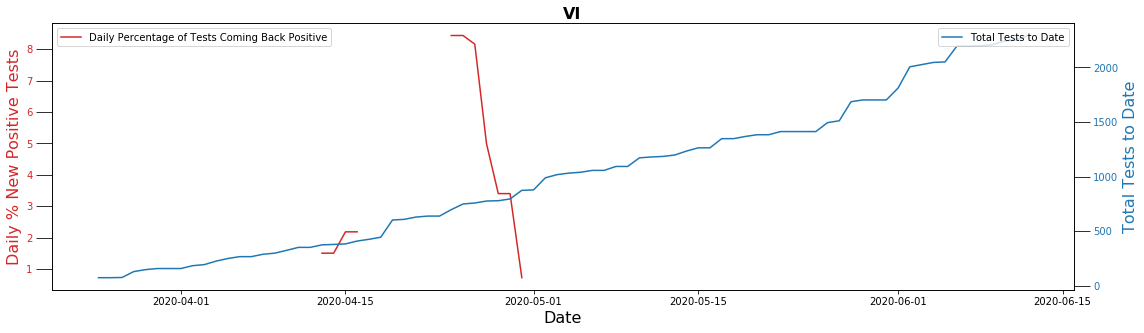

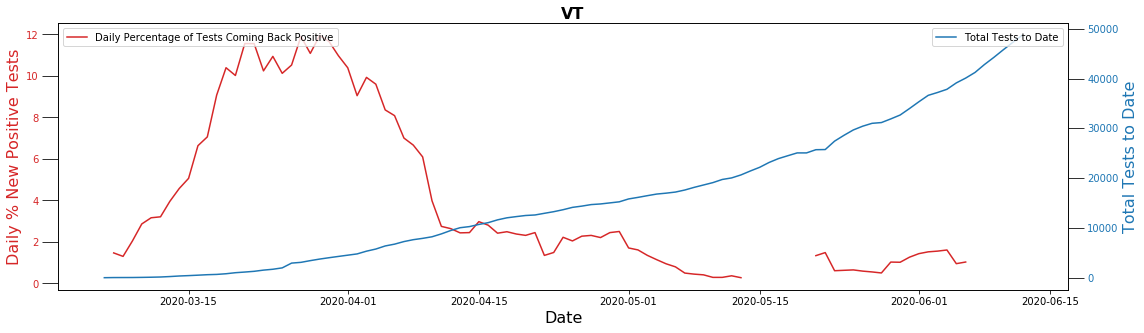

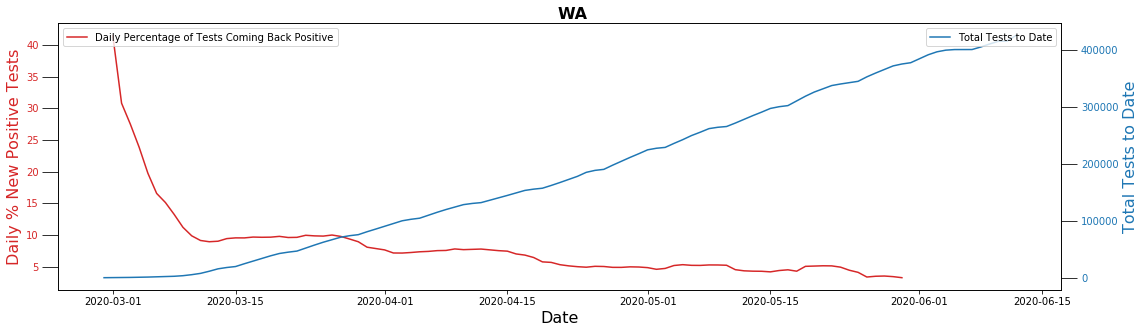

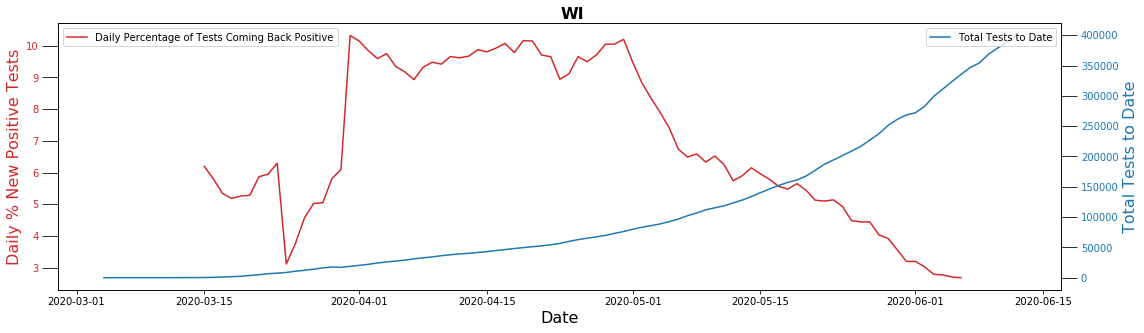

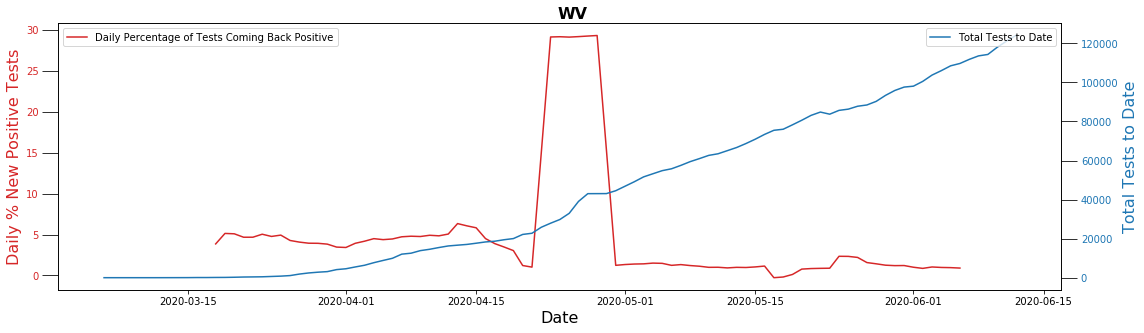

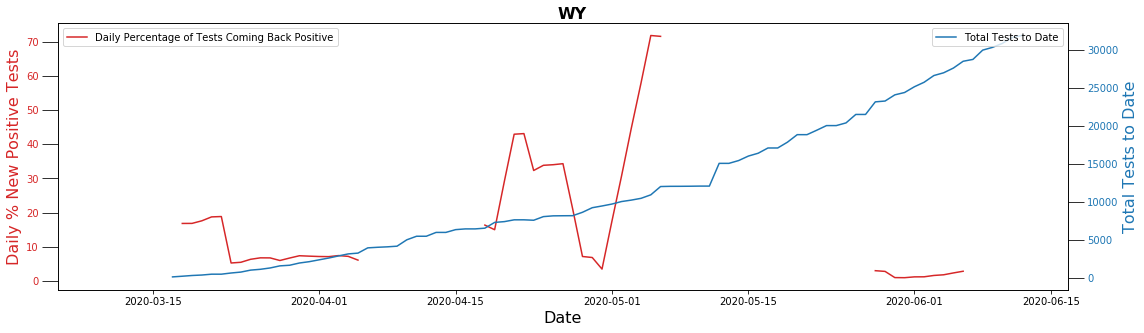

In [33]:
for state in dfs.keys():
    fig, ax1 = plt.subplots(figsize=(16,4.5))
    fig.suptitle(state, size=16, weight='bold', va='baseline') # or plt.suptitle('Main title')
    
    color = 'tab:red'
    ax1.set_xlabel('Date', size=16)
    ax1.set_ylabel('Daily % New Positive Tests', color=color, size=16)
    ax1.plot(dfs[state].index, dfs[state]['daily_pct_pos_rolling'], color=color, label='Daily Percentage of Tests Coming Back Positive')
    ax1.tick_params(axis='y', labelcolor=color, size=16)
    ax1.legend(loc="upper left")
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Total Tests to Date', color=color, size=16)  # we already handled the x-label with ax1
    ax2.plot(dfs[state].index, dfs[state]['total_tests'], color=color, label='Total Tests to Date')
    ax2.tick_params(axis='y', labelcolor=color, size=16)
    ax2.legend(loc="upper right")


    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

### New Cases Rolling Average for Select States

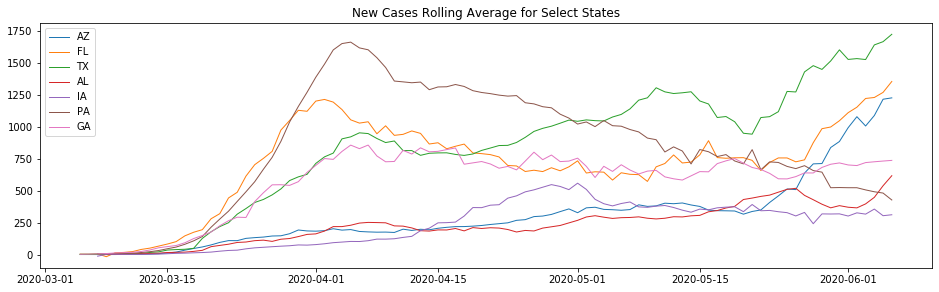

In [20]:
#plt.ylim(0,2000)
#plt.xlim(datetime.date(2020,3,1), datetime.date(2020,6,30))
#plt.xticks(np.arange(datetime.date(2020,3,1), datetime.date(2020,5,15)))
plt.figure(figsize=(16,4.5))
plt.title('New Cases Rolling Average for Select States')
for state in ['AZ','FL','TX','AL','IA','PA','GA']:
    plt.plot(dfs[state].index,dfs[state].new_cases_rolling, label=state, linewidth=1.0)
    fig = plt.legend(loc = 'upper left')

### PER CAPITA New Cases Rolling Average for Select States

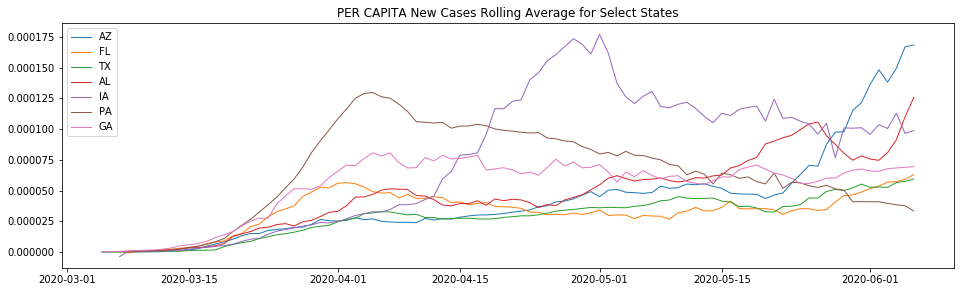

In [22]:
#plt.ylim(0,2000)
#plt.xlim(datetime.date(2020,3,1), datetime.date(2020,6,30))
#plt.xticks(np.arange(datetime.date(2020,3,1), datetime.date(2020,5,15)))
plt.figure(figsize=(16,4.5))
plt.title('PER CAPITA New Cases Rolling Average for Select States')
for state in ['AZ','FL','TX','AL','IA','PA','GA']:
    plt.plot(dfs[state].index,dfs[state].new_cases_rolling_pc, label=state, linewidth=1.0)
    fig = plt.legend(loc = 'upper left')

### New Deaths Rolling Average for Select States

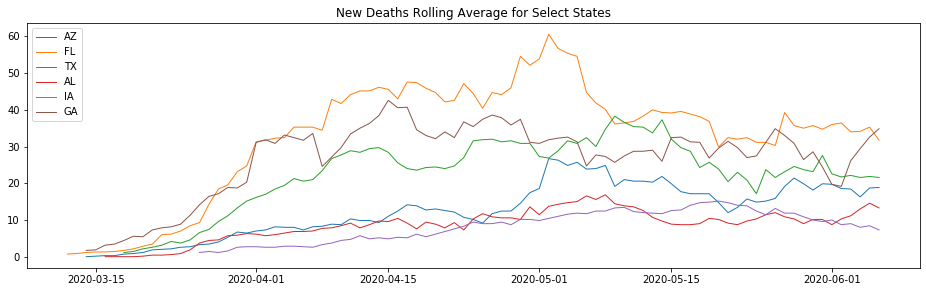

In [23]:
#plt.ylim(0,2000)
#plt.xlim(datetime.date(2020,3,1), datetime.date(2020,6,15))
#plt.xticks(np.arange(datetime.date(2020,3,1), datetime.date(2020,5,15)))
plt.figure(figsize=(16,4.5))
plt.title('New Deaths Rolling Average for Select States')
for state in ['AZ','FL','TX','AL','IA','GA']:
    plt.plot(dfs[state].index,dfs[state].new_deaths_rolling, label=state, linewidth=1.0)
    fig = plt.legend(loc = 'upper left')

### PER CAPITA New Deaths Rolling Average for Select States

In [ ]:
#plt.ylim(0,2000)
#plt.xlim(datetime.date(2020,3,1), datetime.date(2020,6,15))
#plt.xticks(np.arange(datetime.date(2020,3,1), datetime.date(2020,5,15)))
plt.figure(figsize=(16,4.5))
plt.title('New Deaths Rolling Average for Select States')
for state in ['AZ','FL','TX','AL','IA','GA']:
    plt.plot(dfs[state].index,dfs[state].new_deaths_rolling_pc, label=state, linewidth=1.0)
    fig = plt.legend(loc = 'upper left')

### Rolling Averages of New Cases, Hospitalizations, Deaths: National and State

/Users/adamjfr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


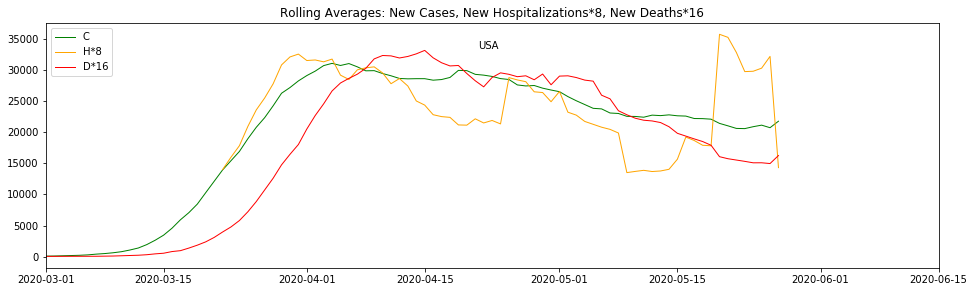

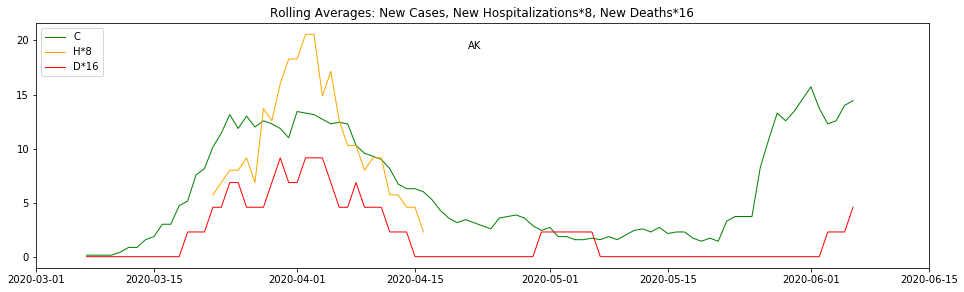

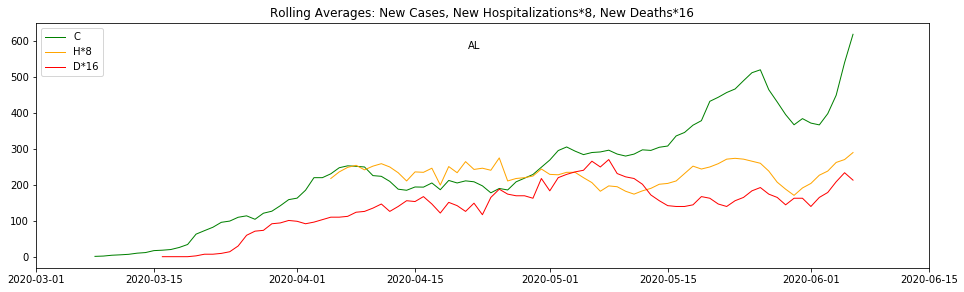

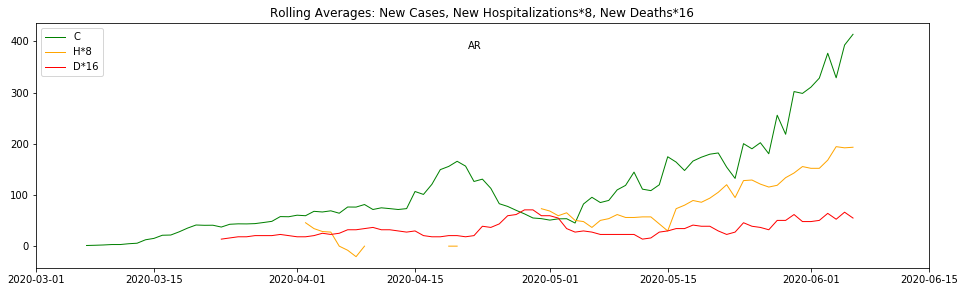

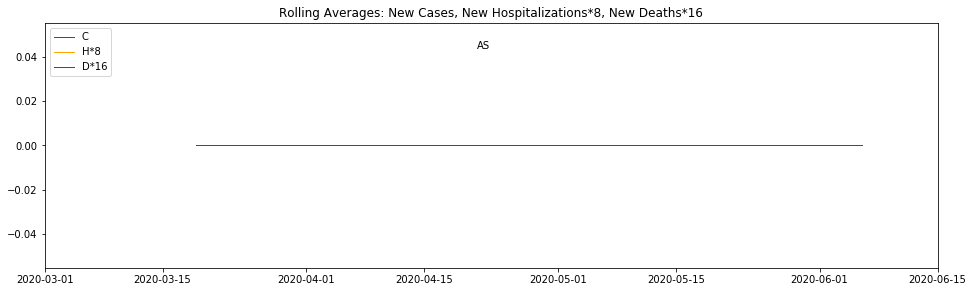

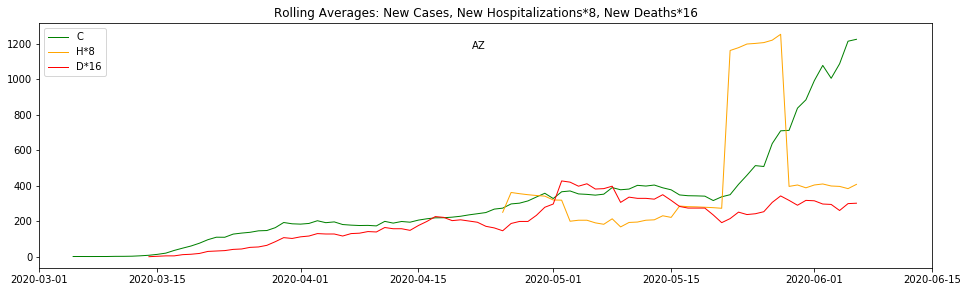

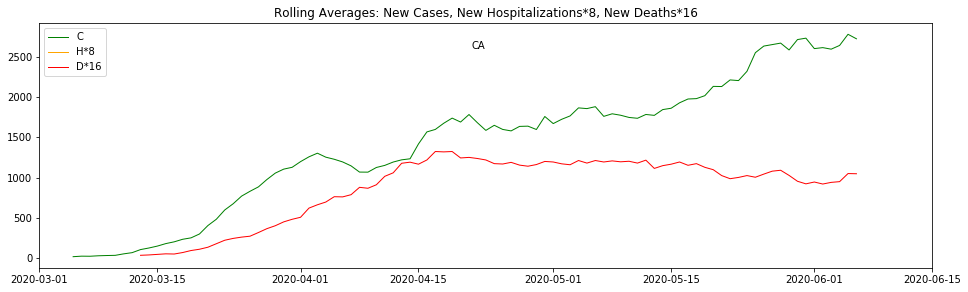

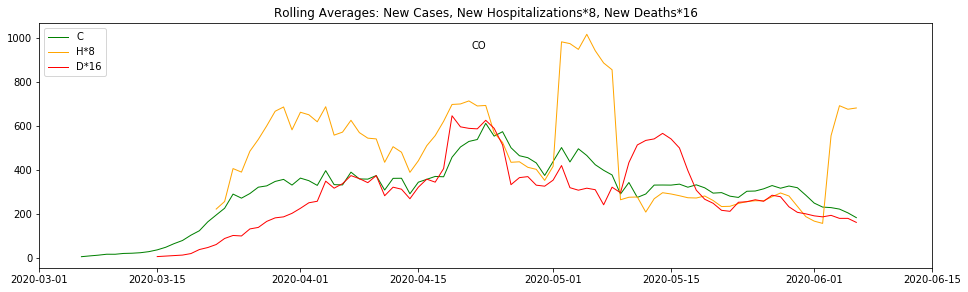

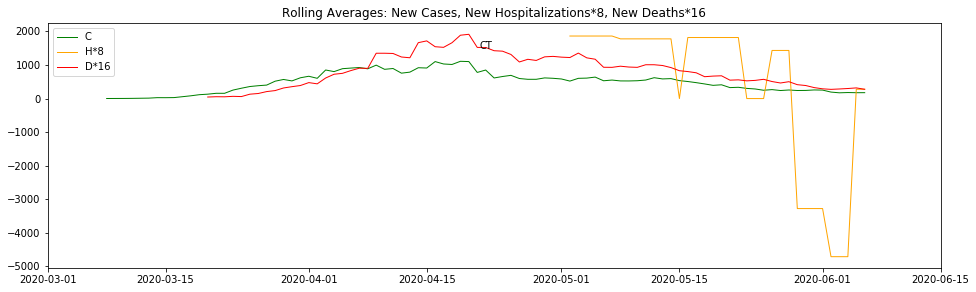

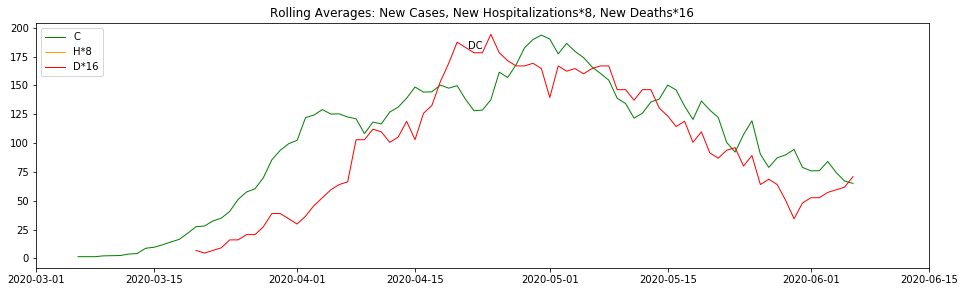

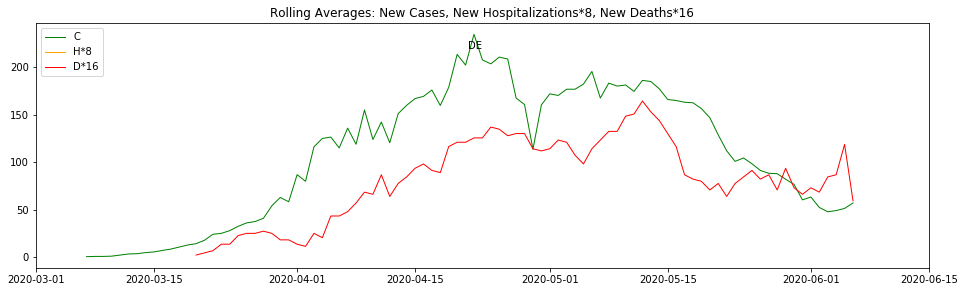

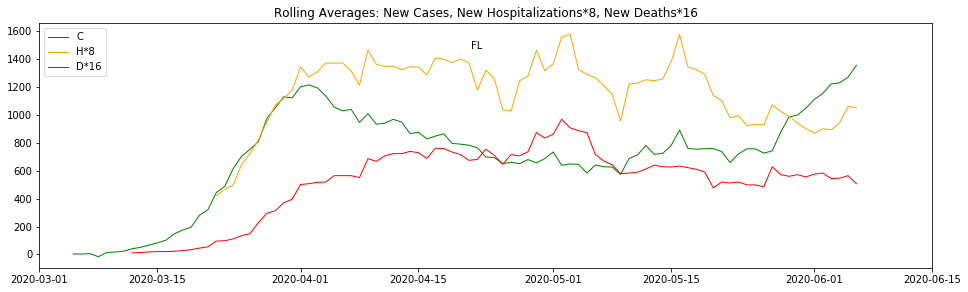

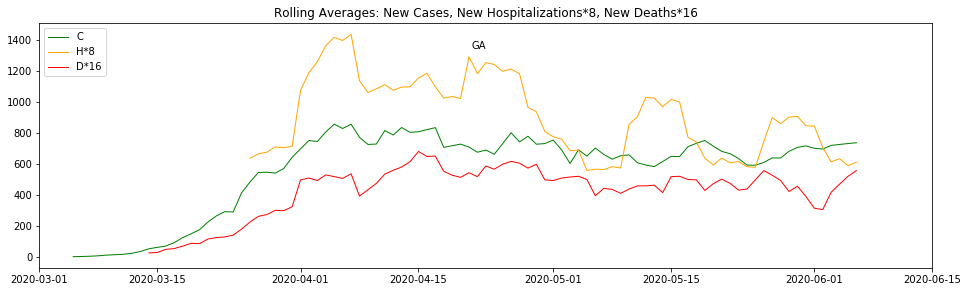

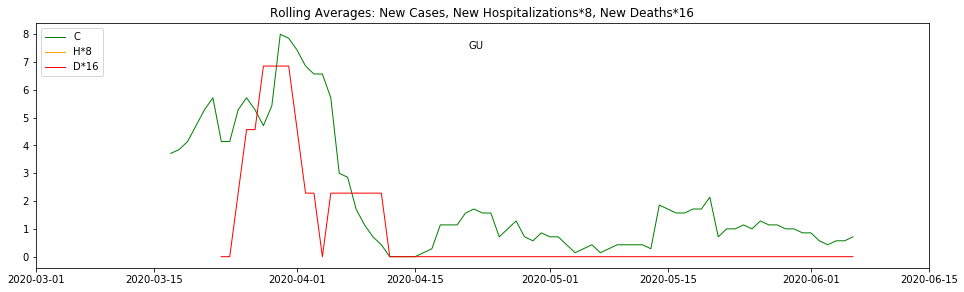

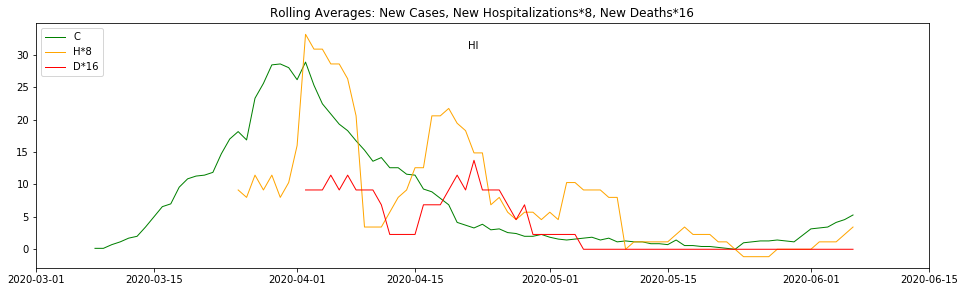

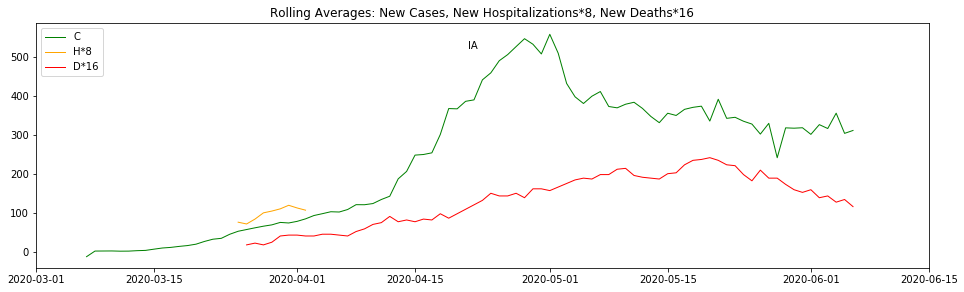

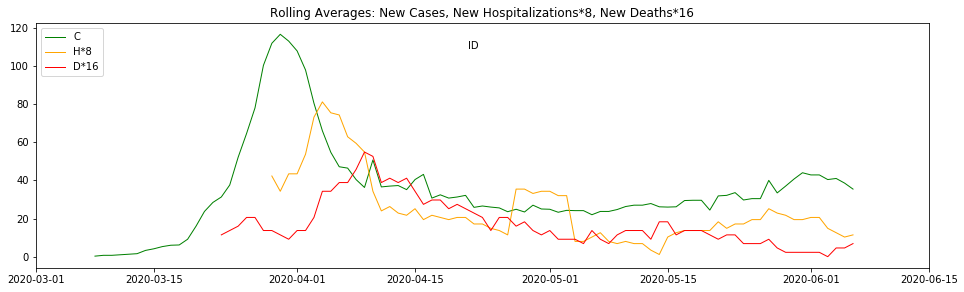

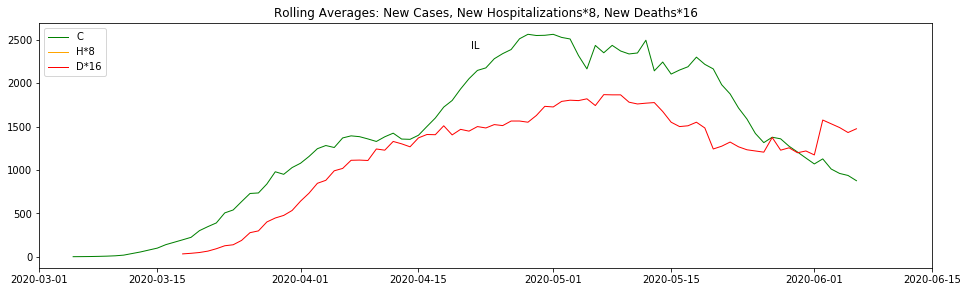

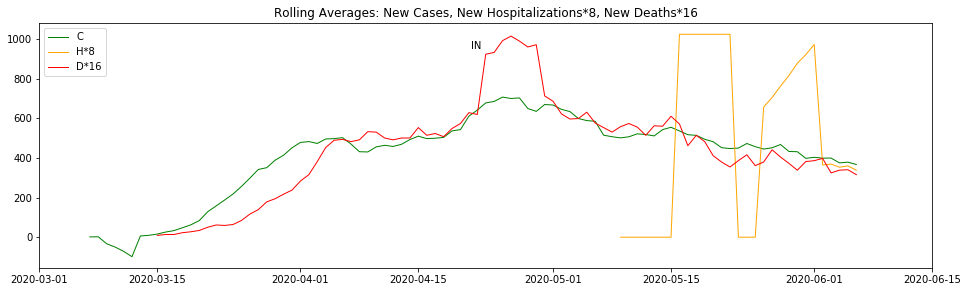

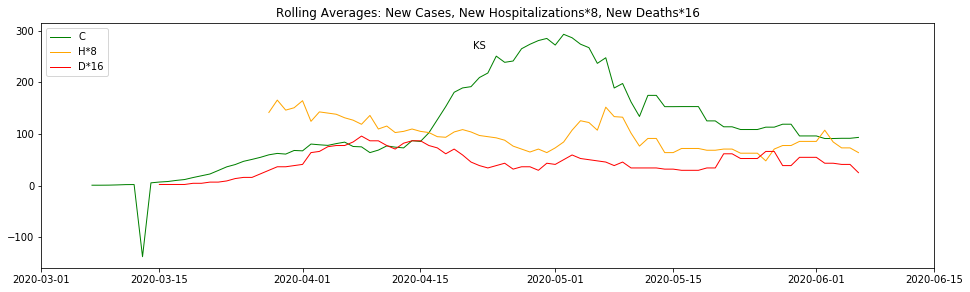

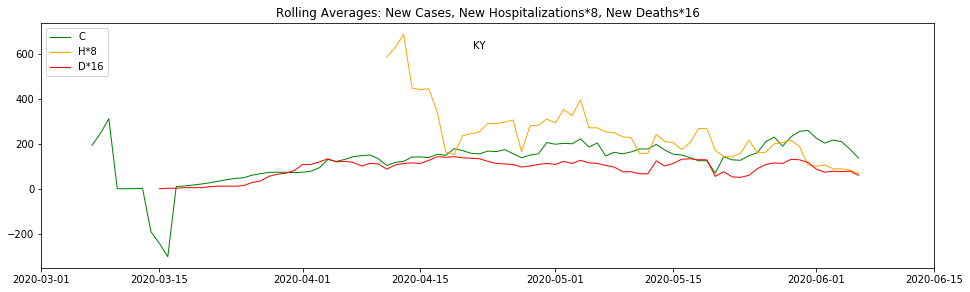

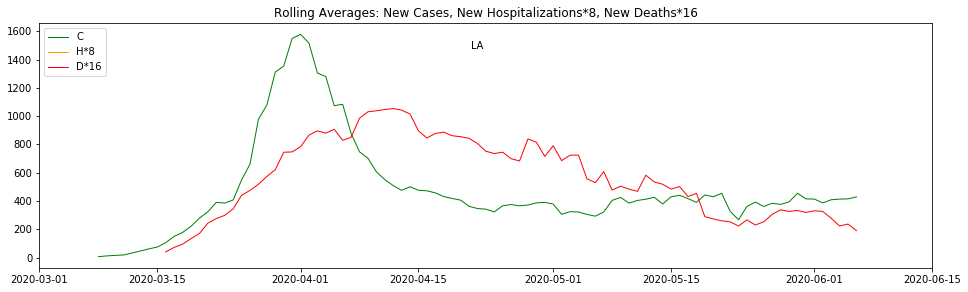

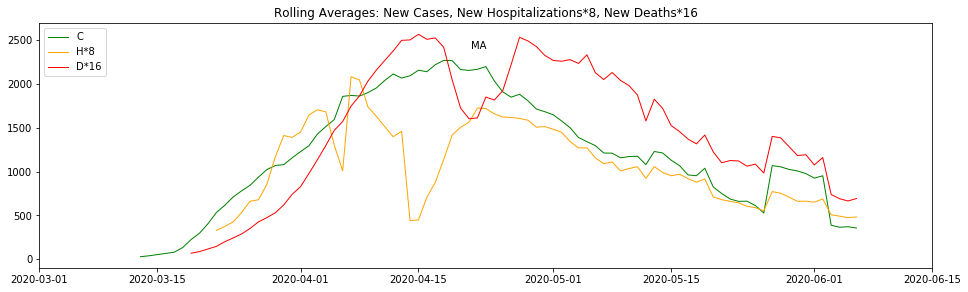

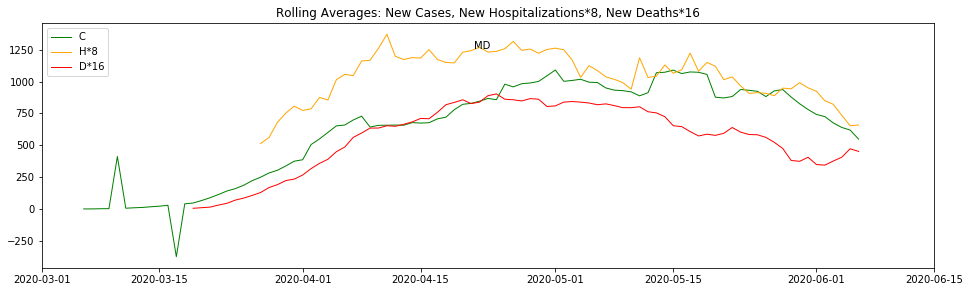

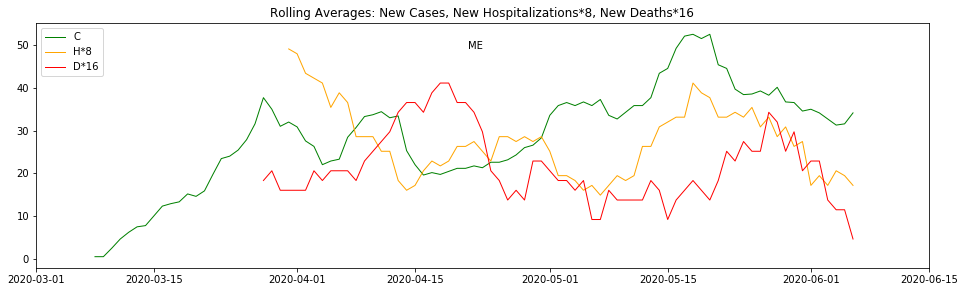

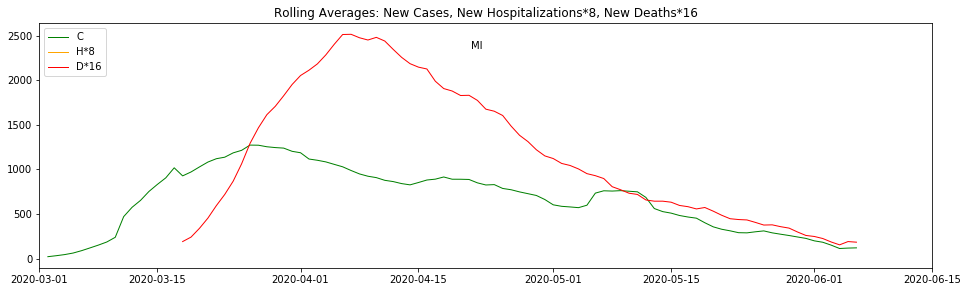

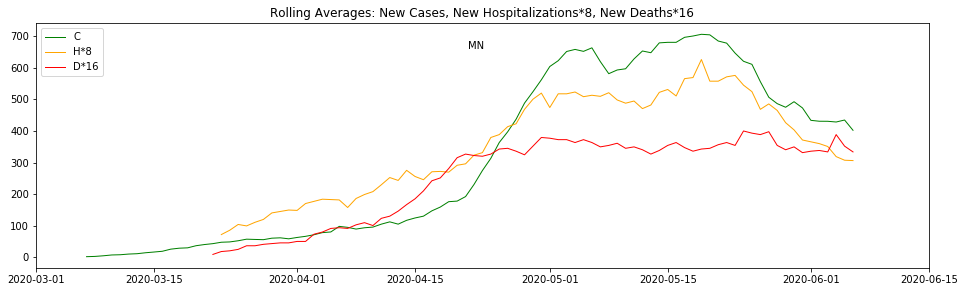

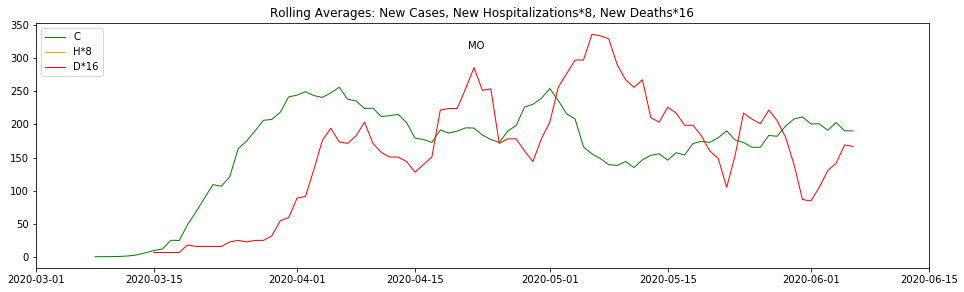

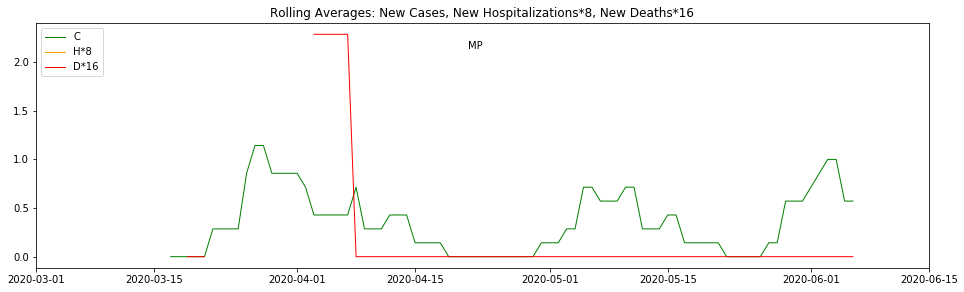

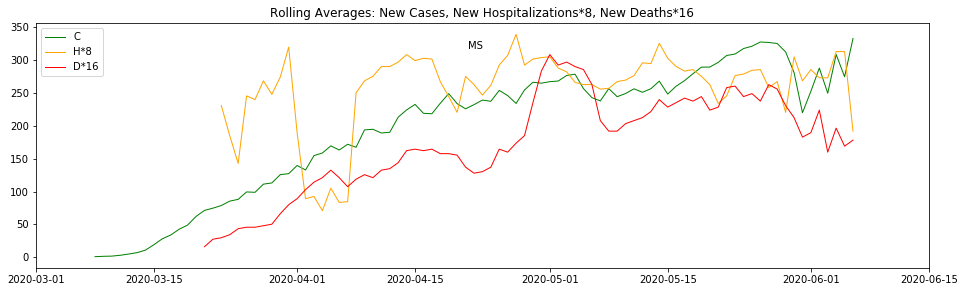

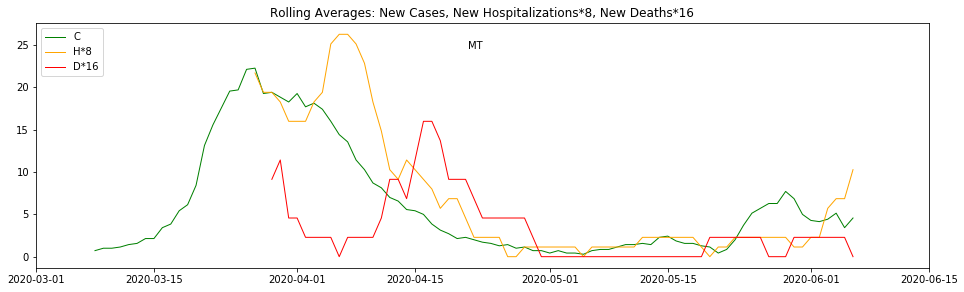

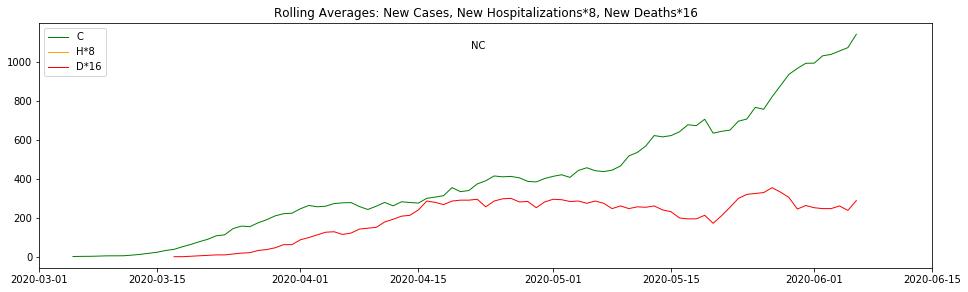

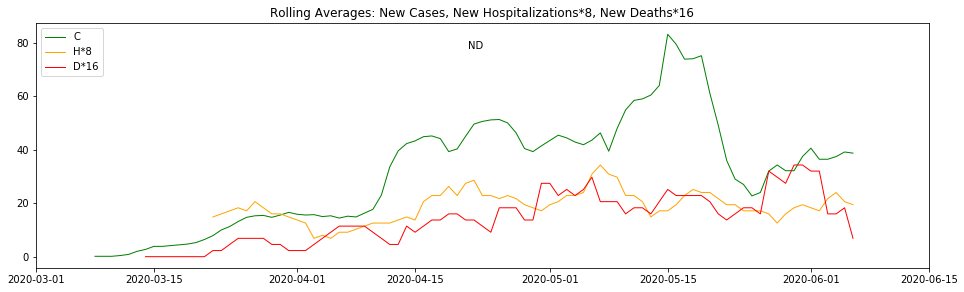

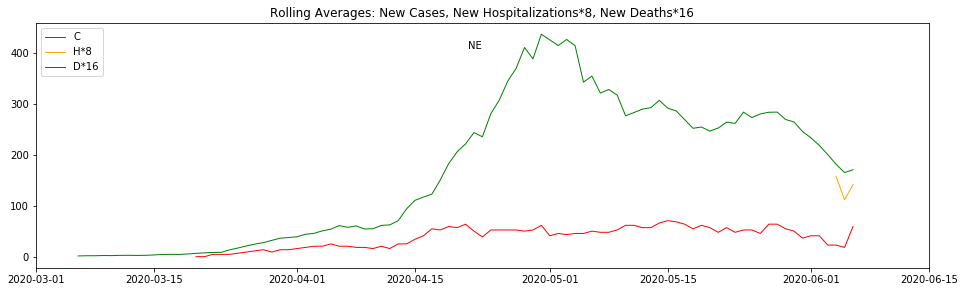

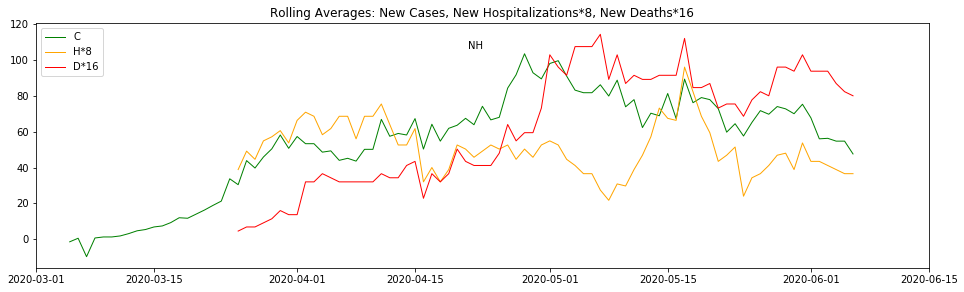

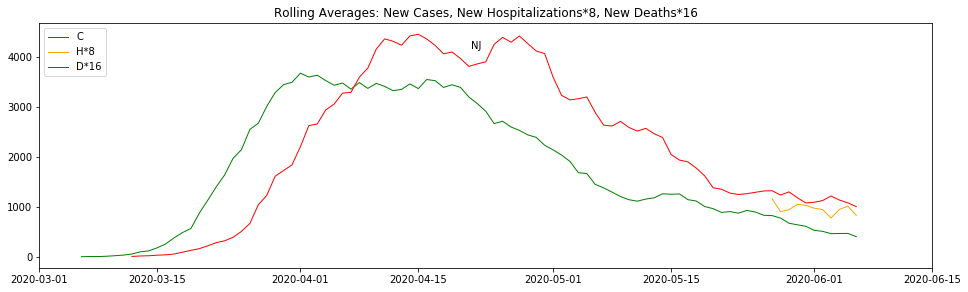

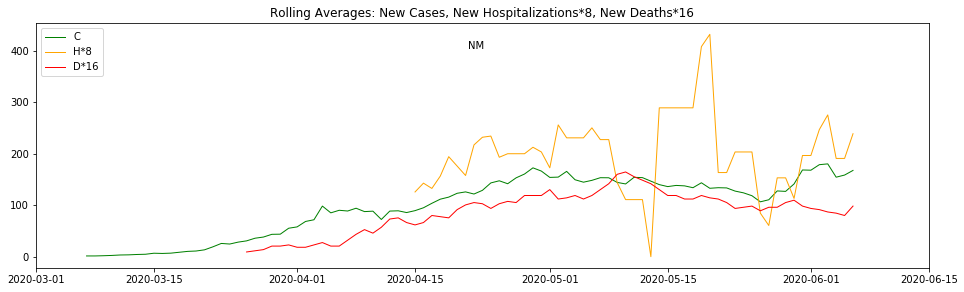

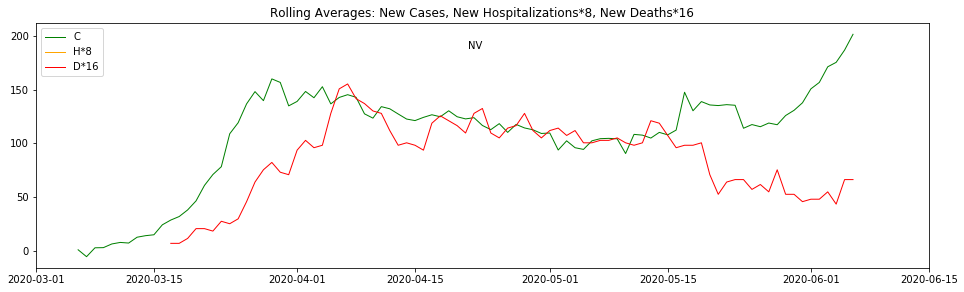

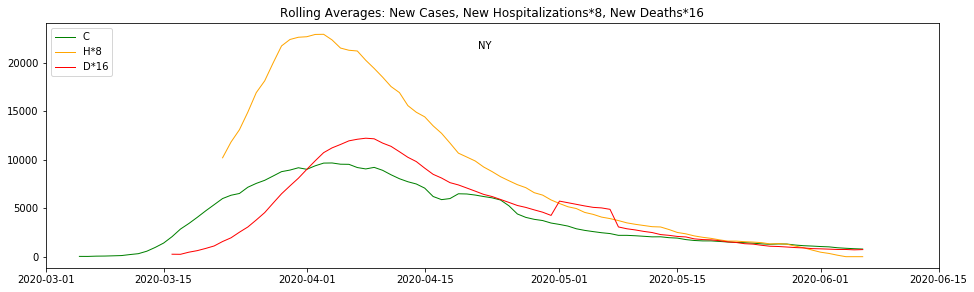

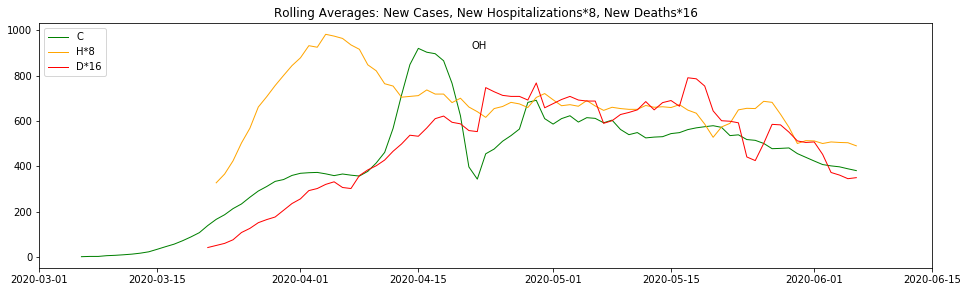

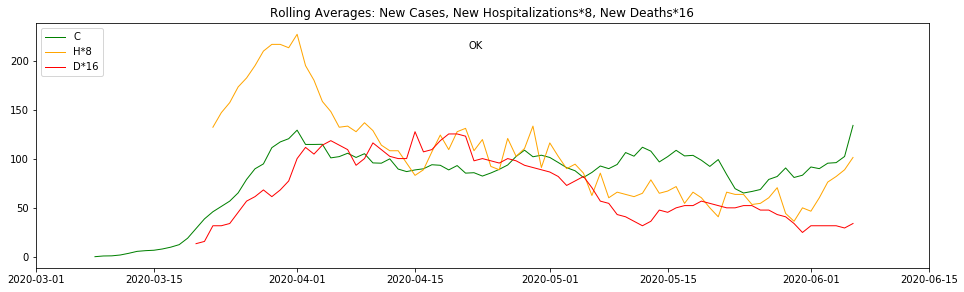

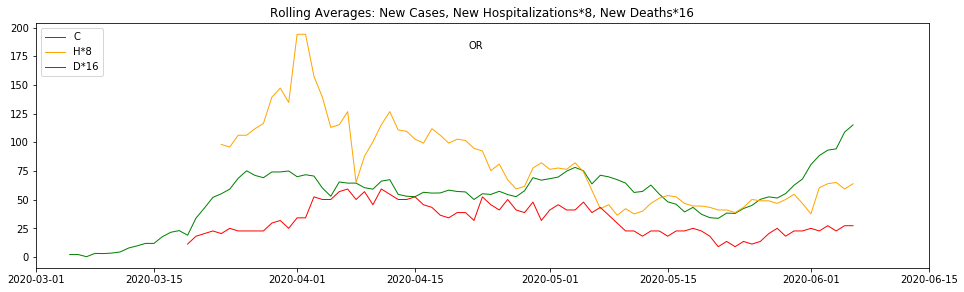

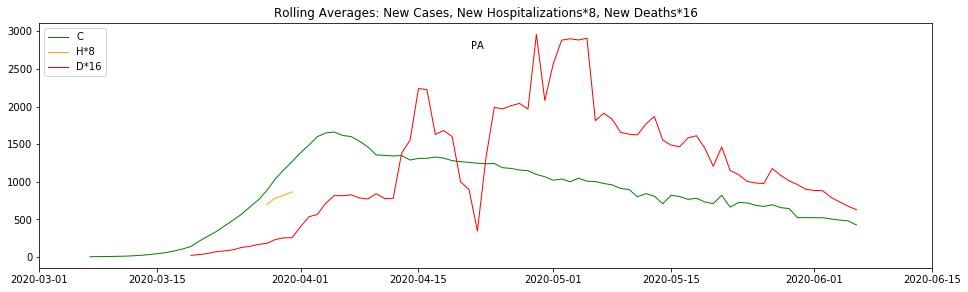

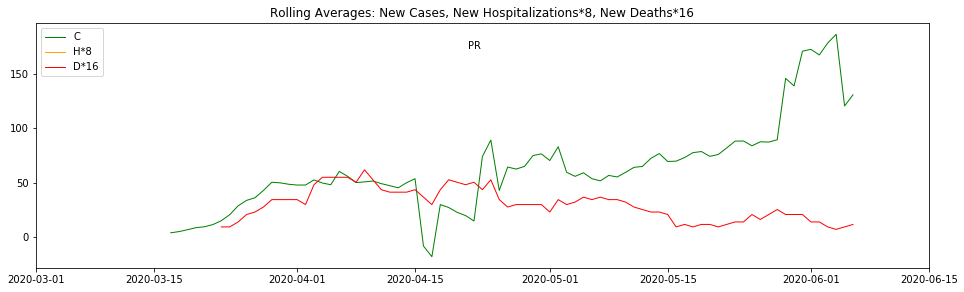

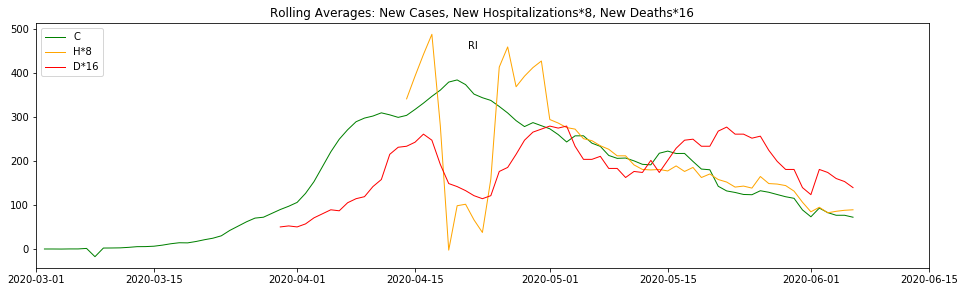

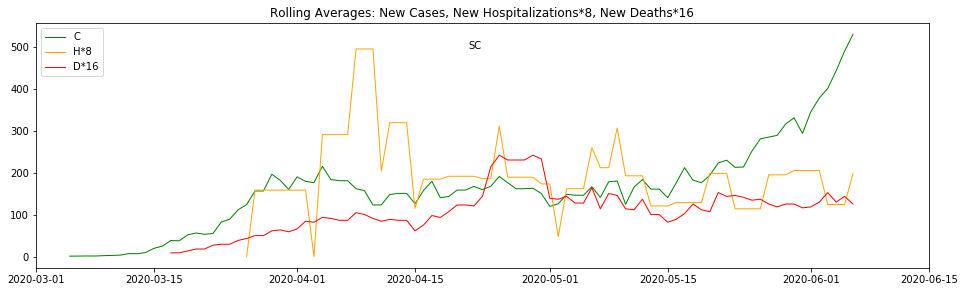

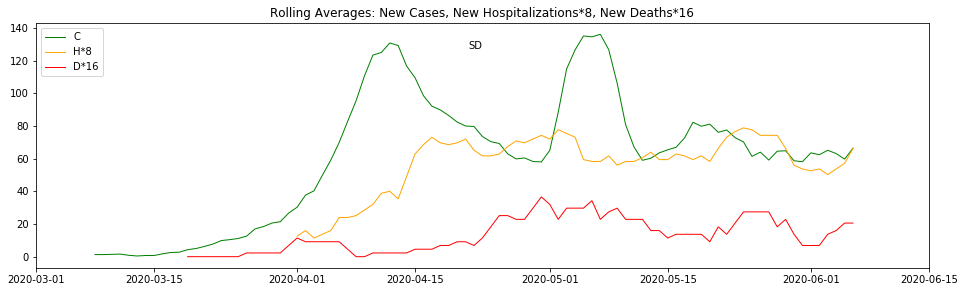

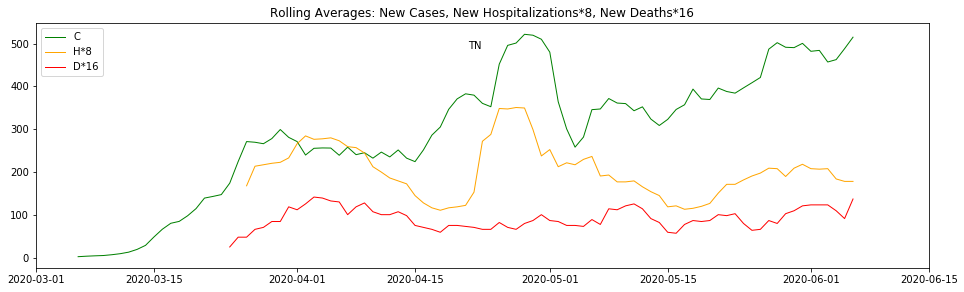

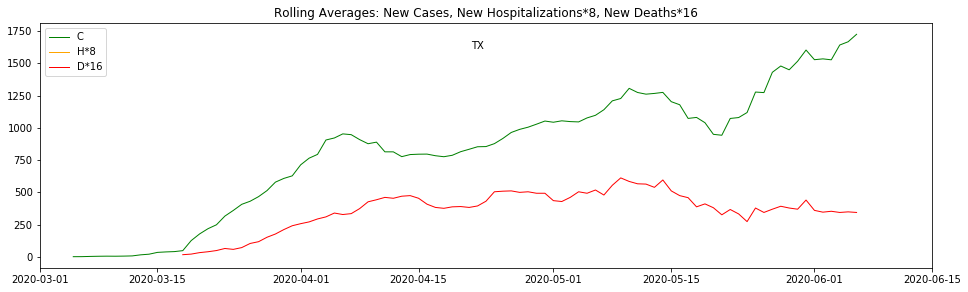

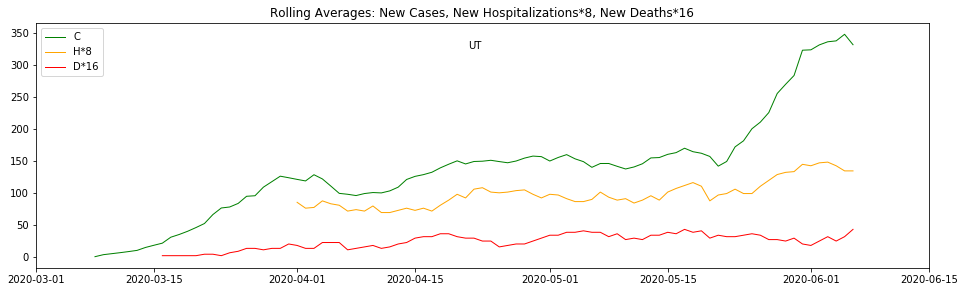

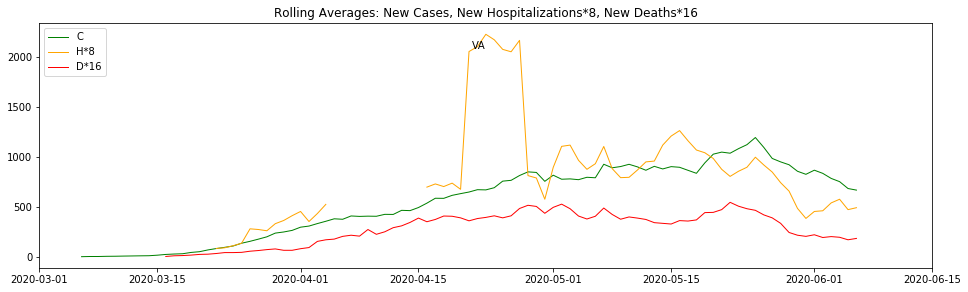

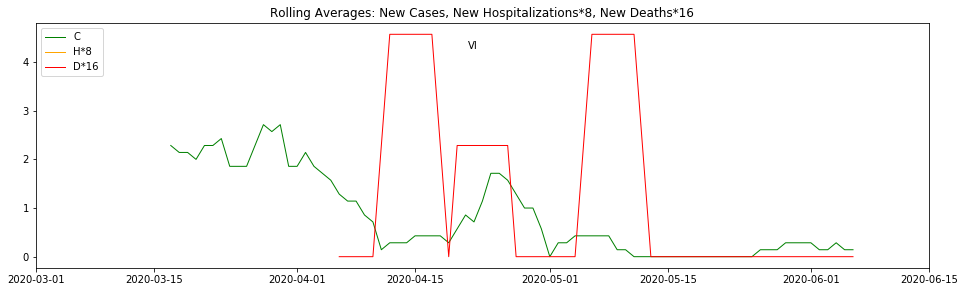

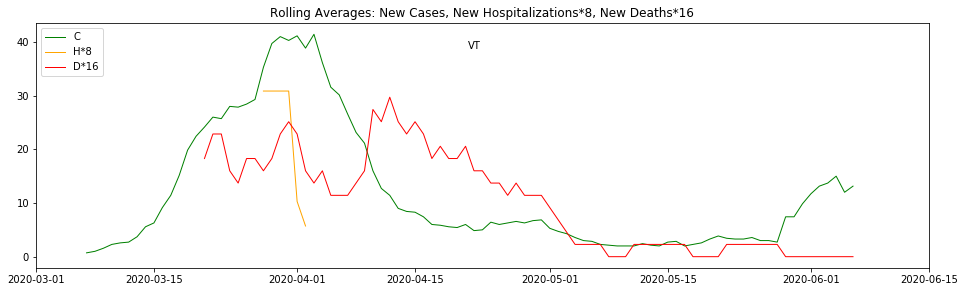

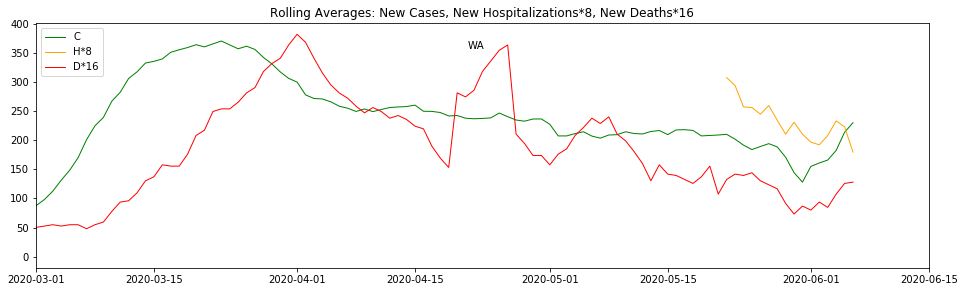

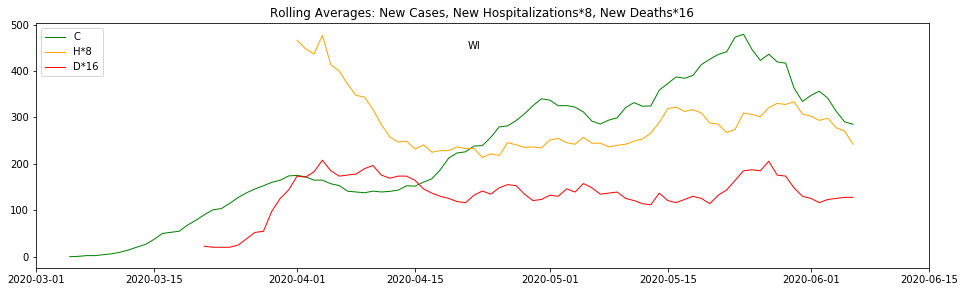

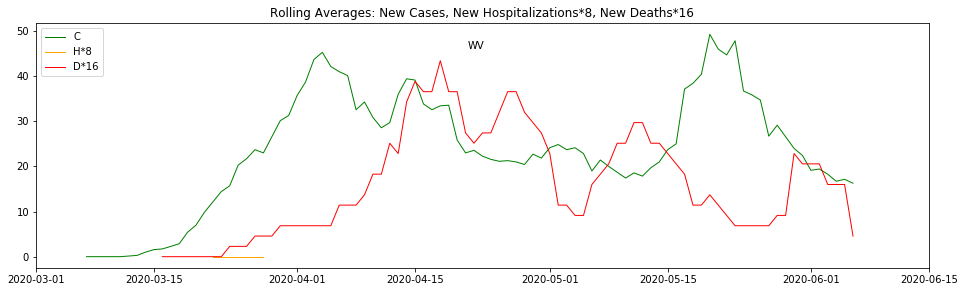

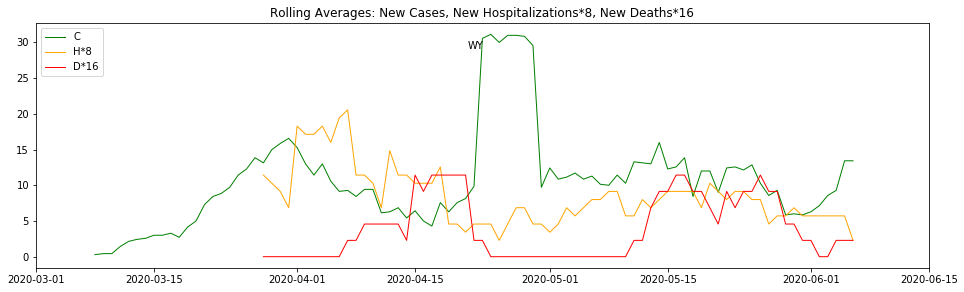

In [24]:
#plt.ylim(0,3000)

for state in dfs.keys():
    plt.figure(figsize=(16,4.5)) 
    plt.xlim(datetime.date(2020,3,1), datetime.date(2020,6,15))
   # plt.xticks([datetime.date(2020,3,1), datetime.date(2020,4,1), datetime.date(2020,5,1)])
    plt.title(label=f"Rolling Averages: New Cases, New Hospitalizations*8, New Deaths*16")
    plt.figtext(0.5,0.8,state)

    plt.plot(dfs[state].index,dfs[state].new_cases_rolling, label='C', color='green', linewidth=1.0)
    plt.plot(dfs[state].index,dfs[state].new_hosp_rolling*8, label='H*8', color='orange', linewidth=1.0)
    plt.plot(dfs[state].index,dfs[state].new_deaths_rolling*16, label='D*16', color='red', linewidth=1.0)

    fig = plt.legend(loc = 'upper left')

### Daily Growth Factor: National and State

/Users/adamjfr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


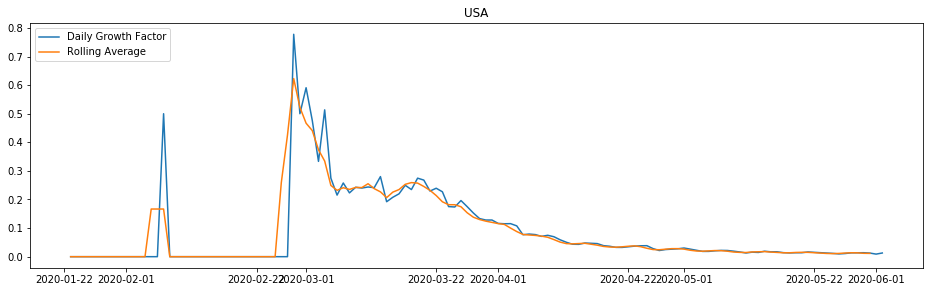

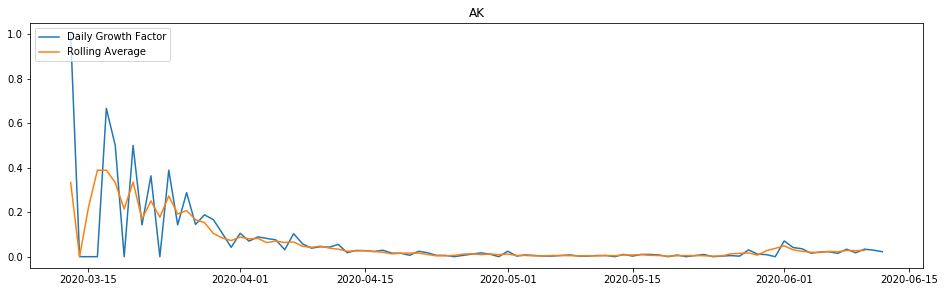

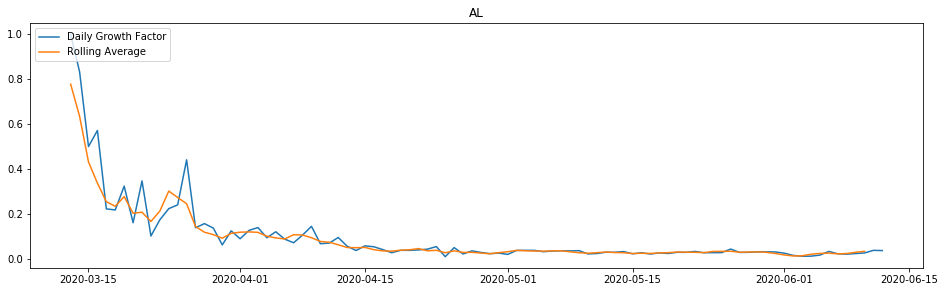

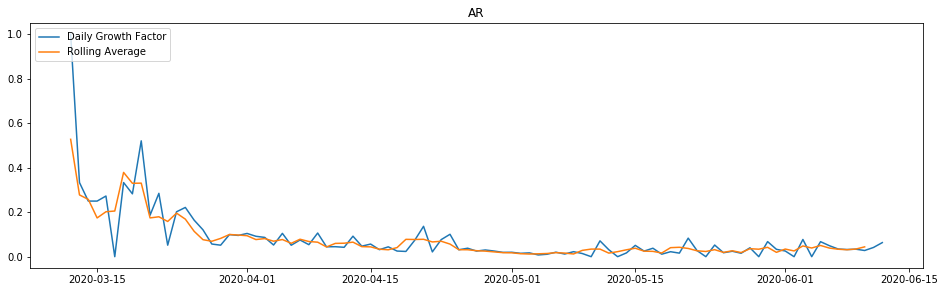

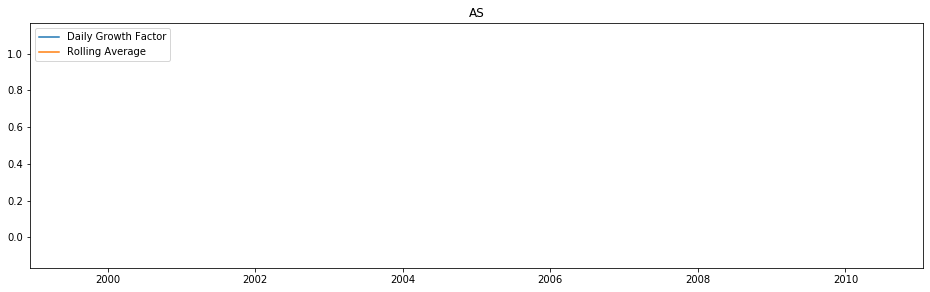

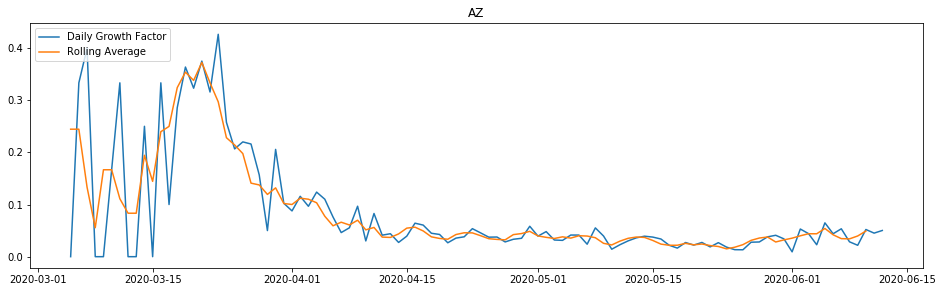

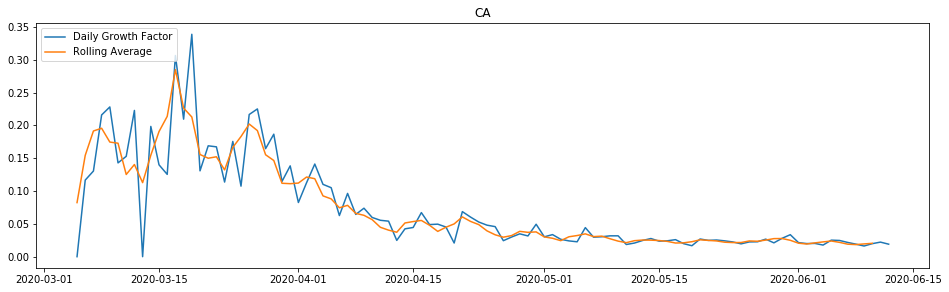

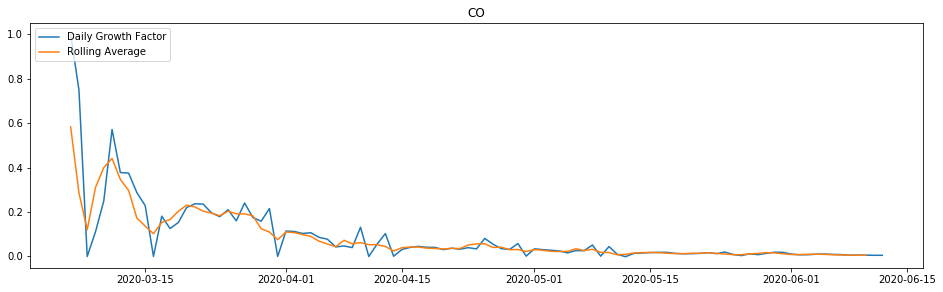

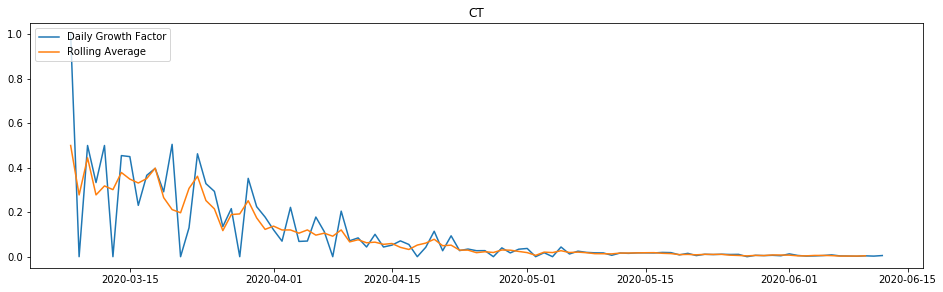

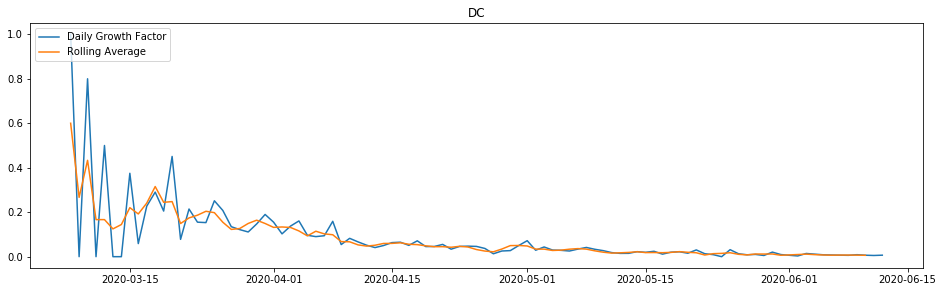

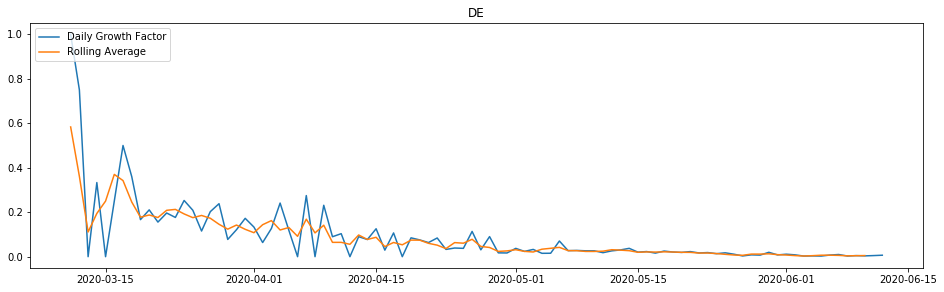

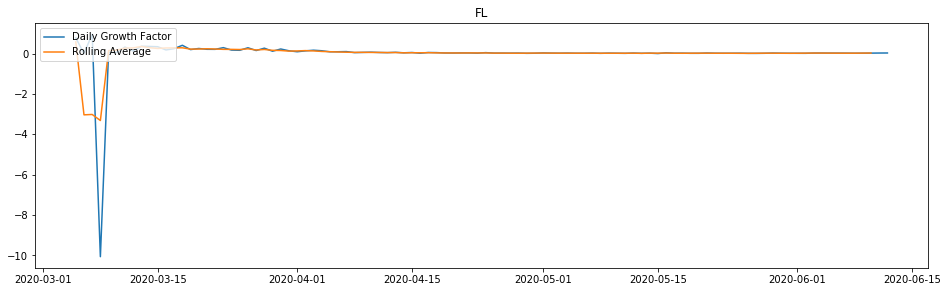

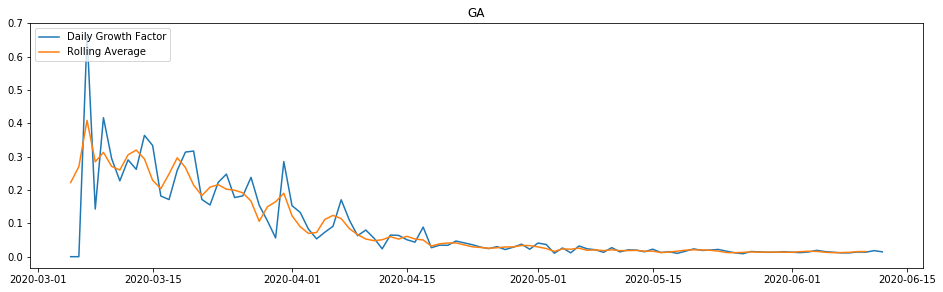

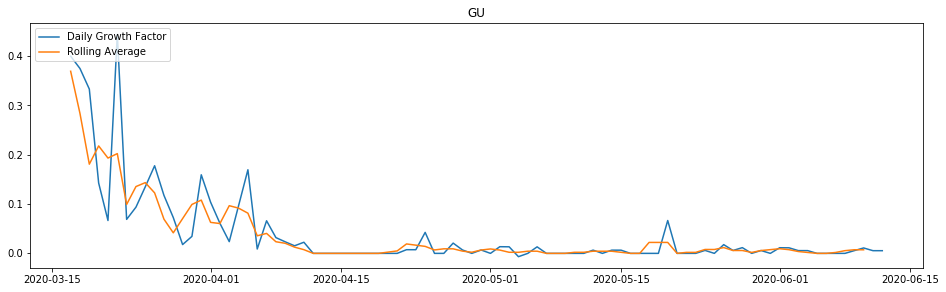

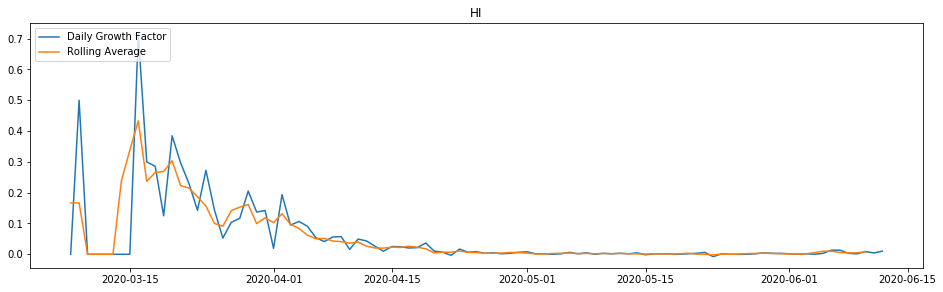

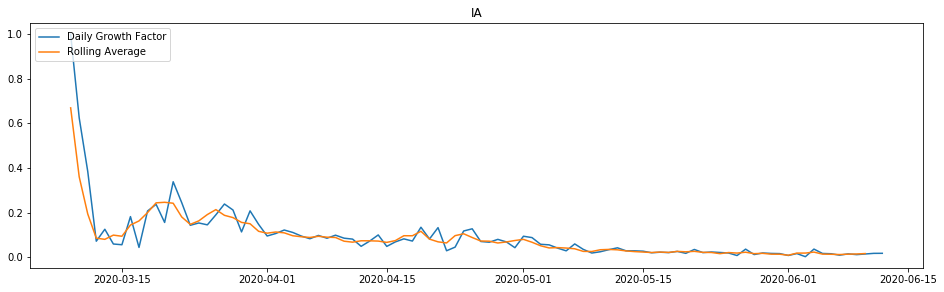

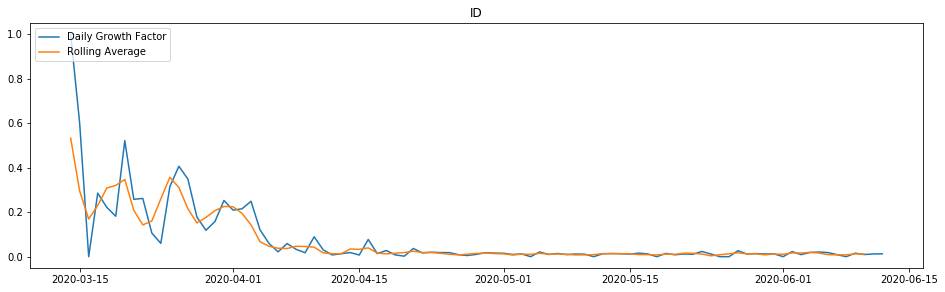

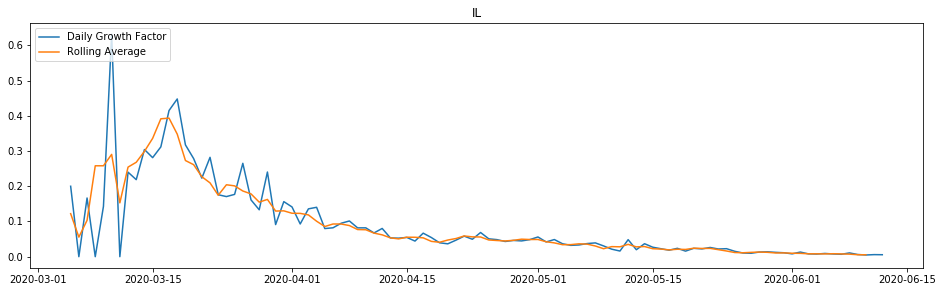

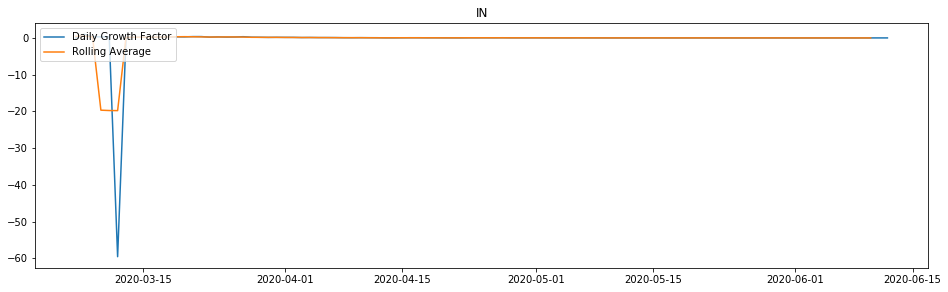

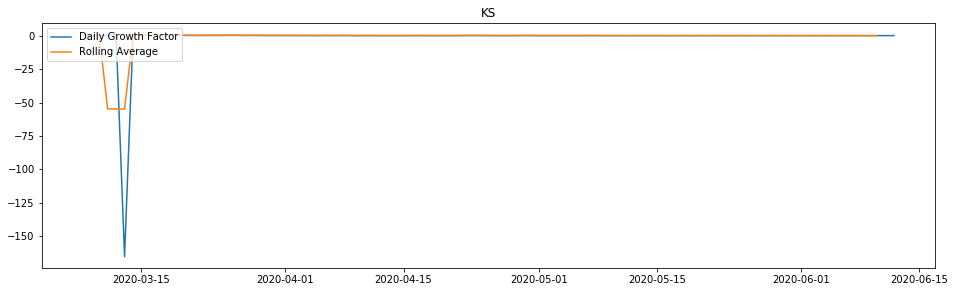

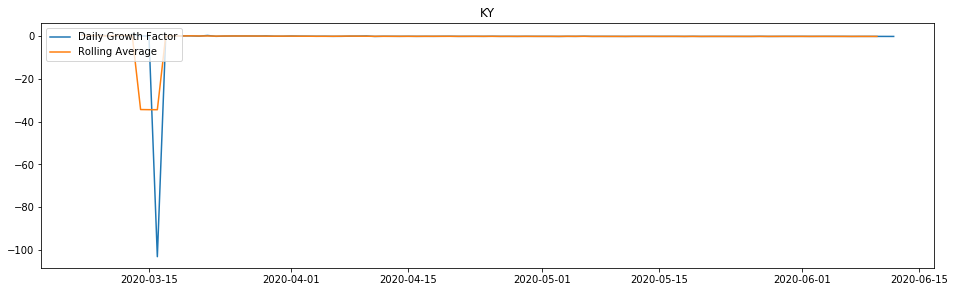

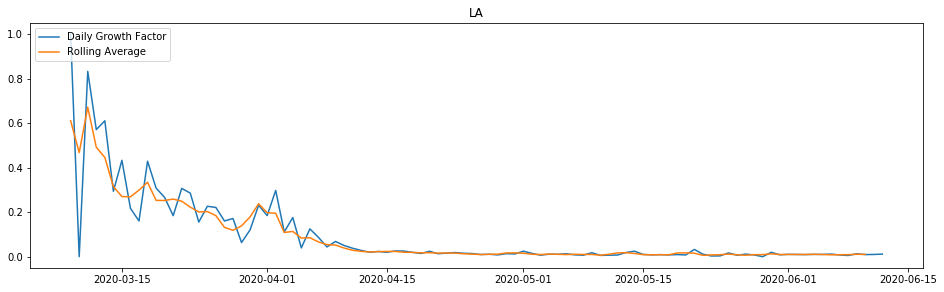

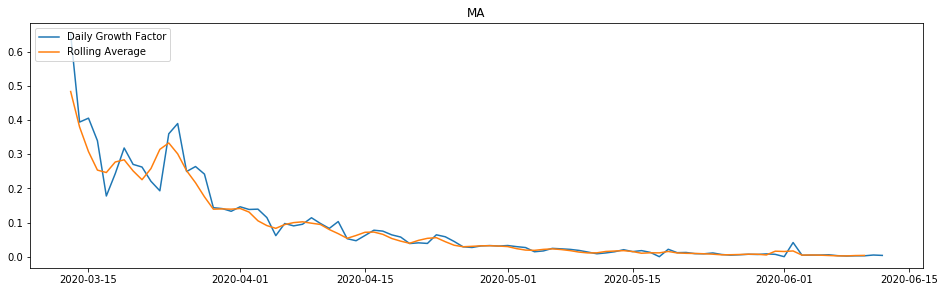

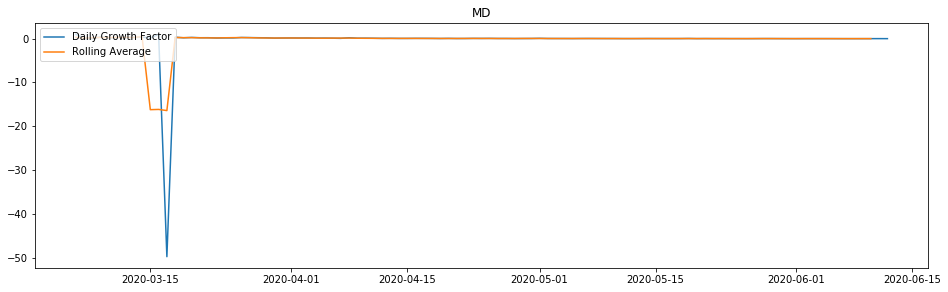

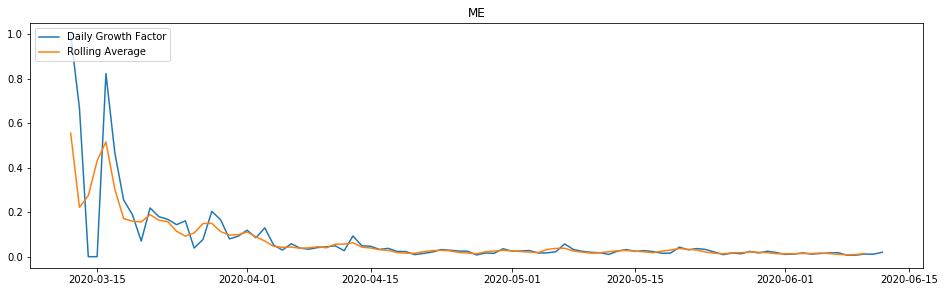

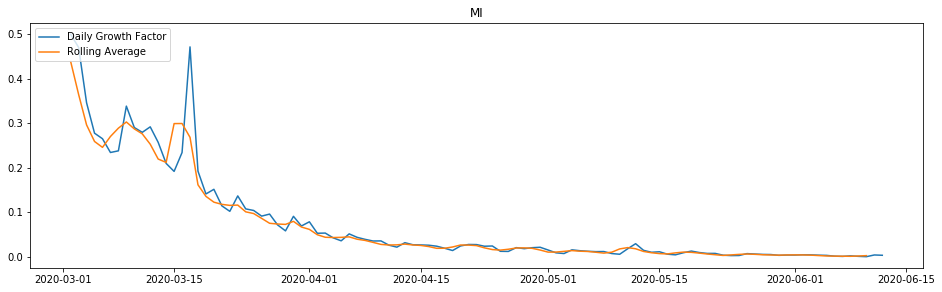

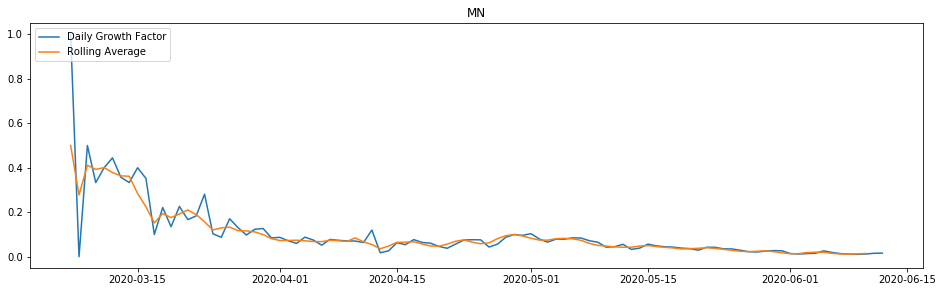

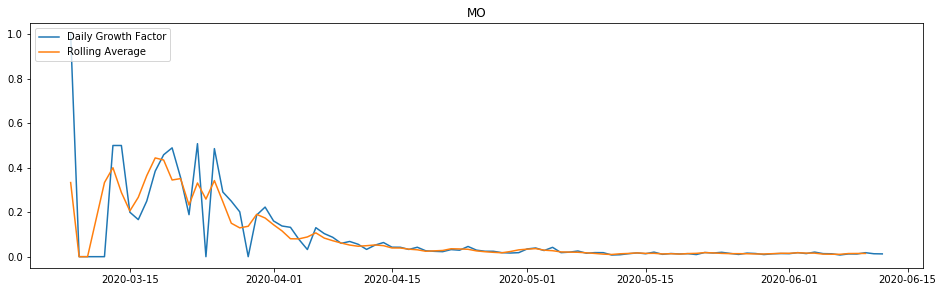

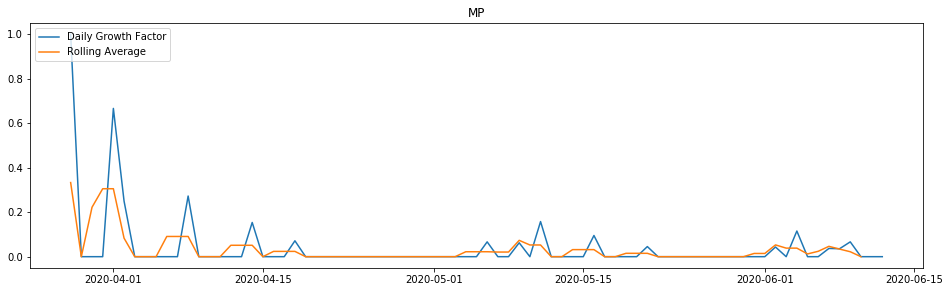

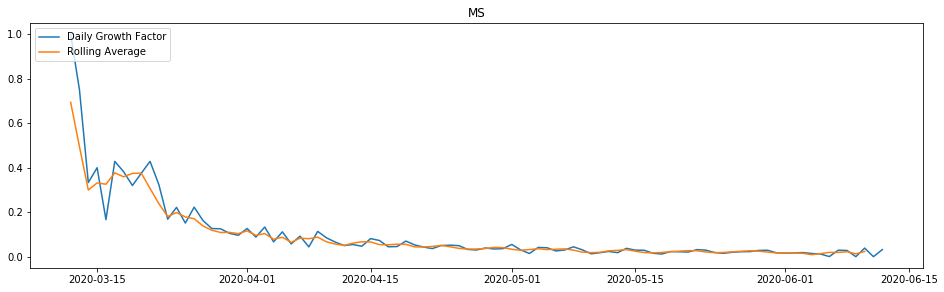

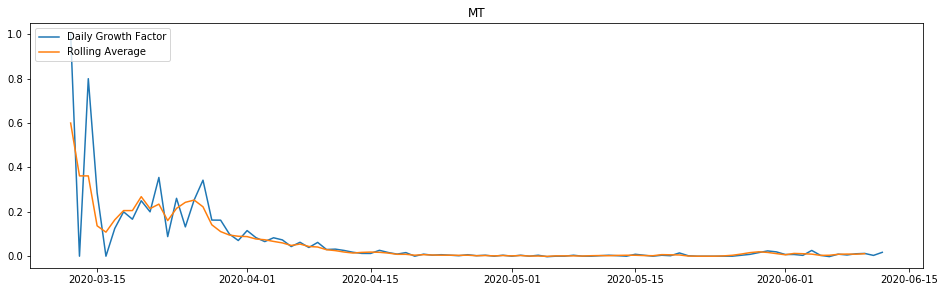

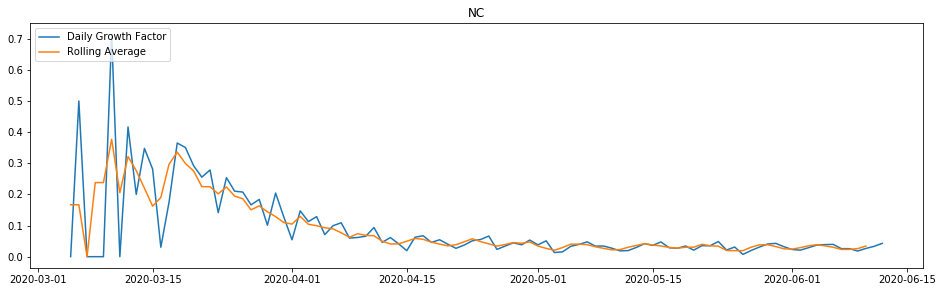

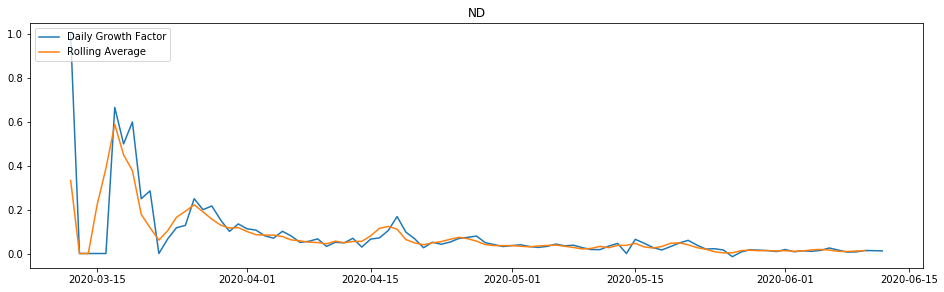

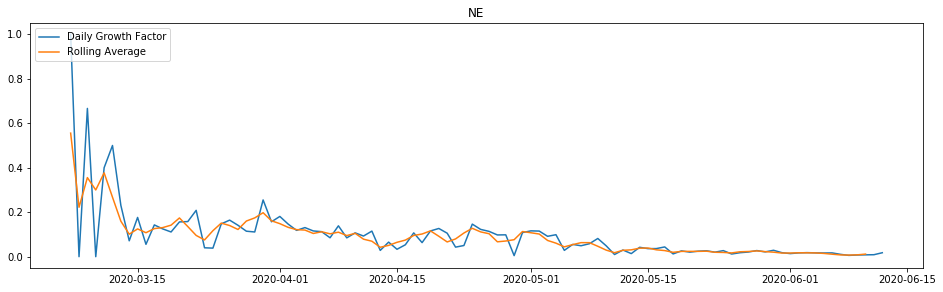

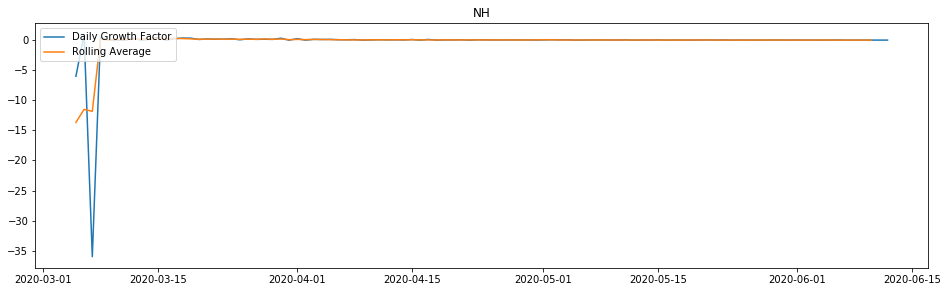

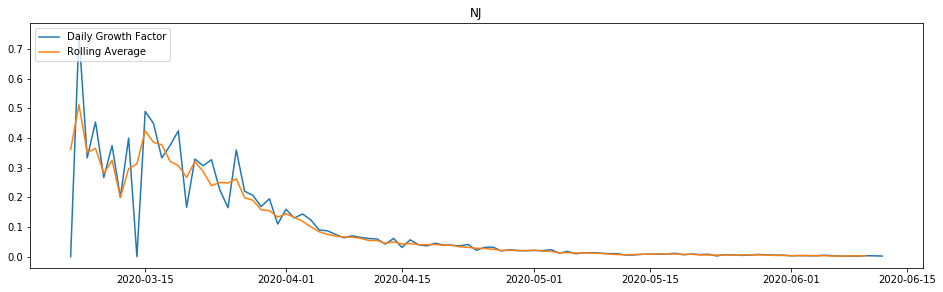

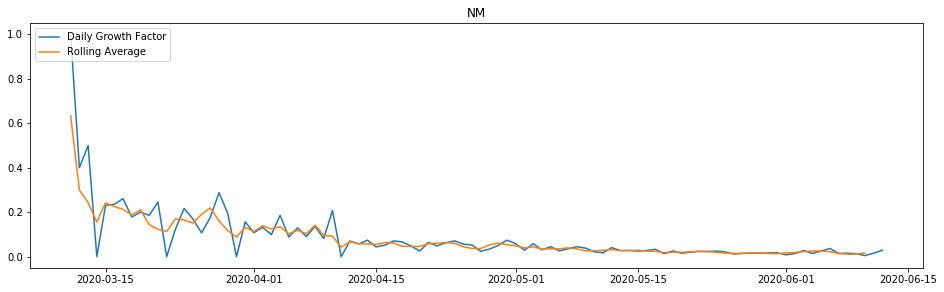

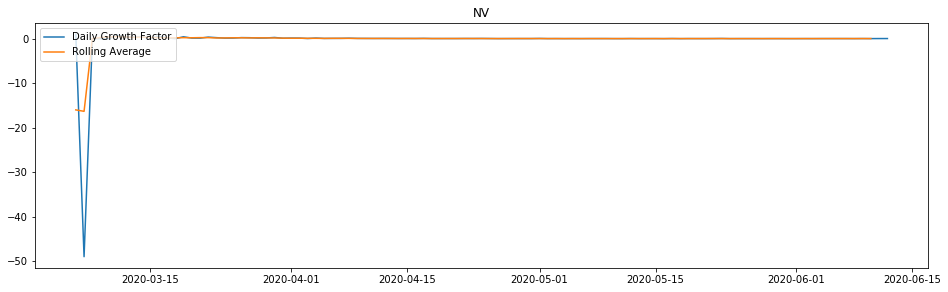

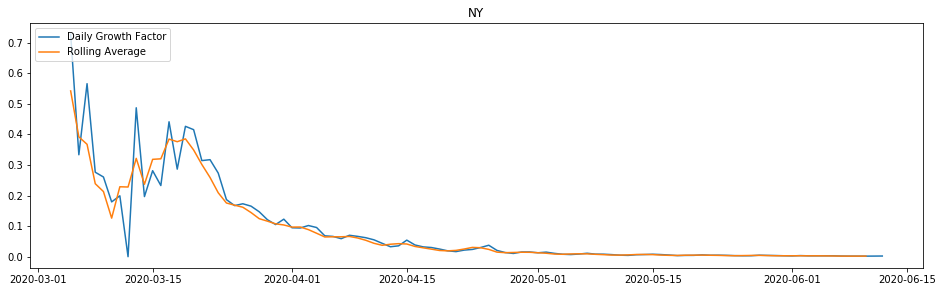

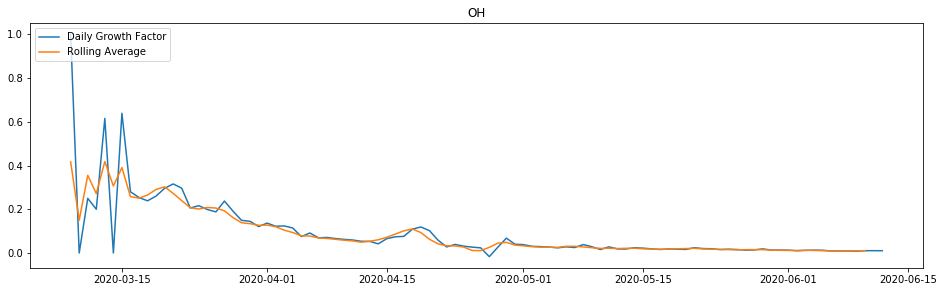

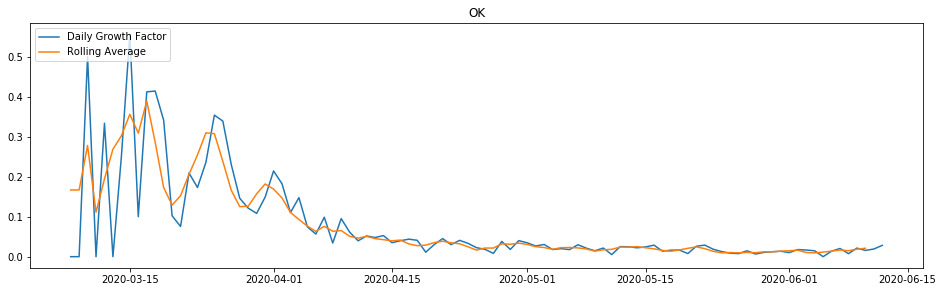

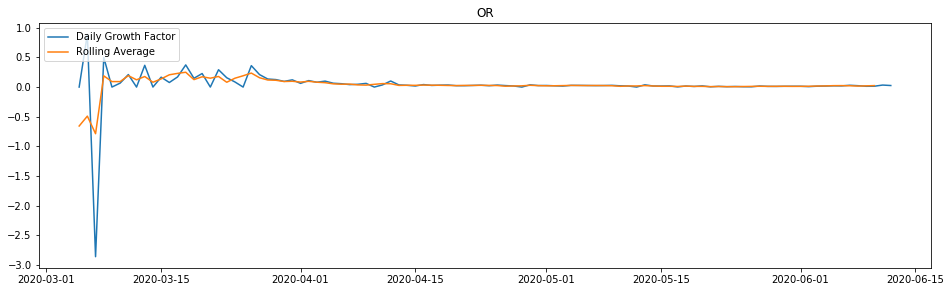

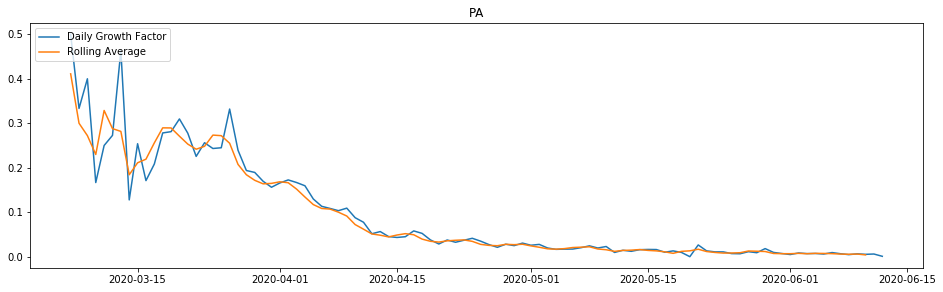

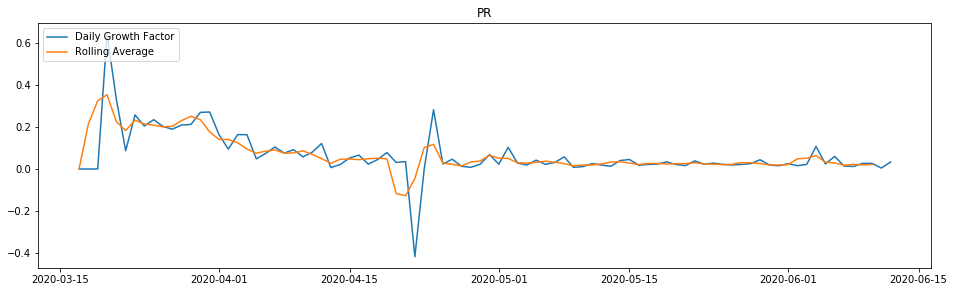

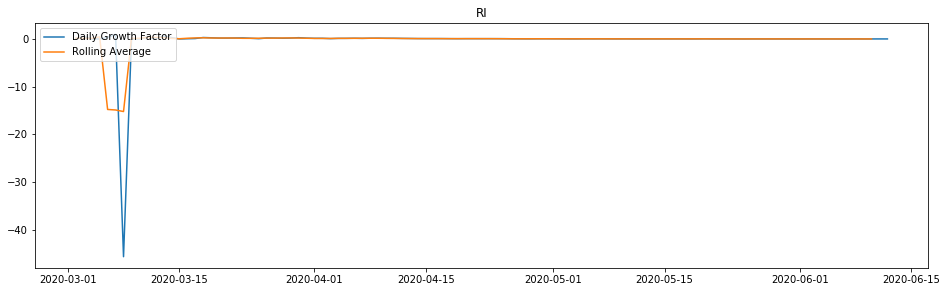

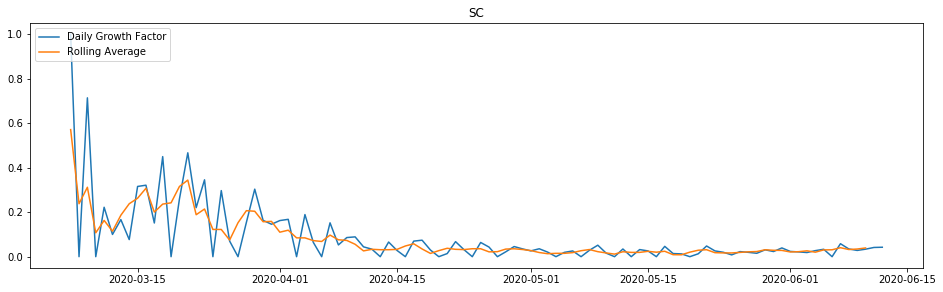

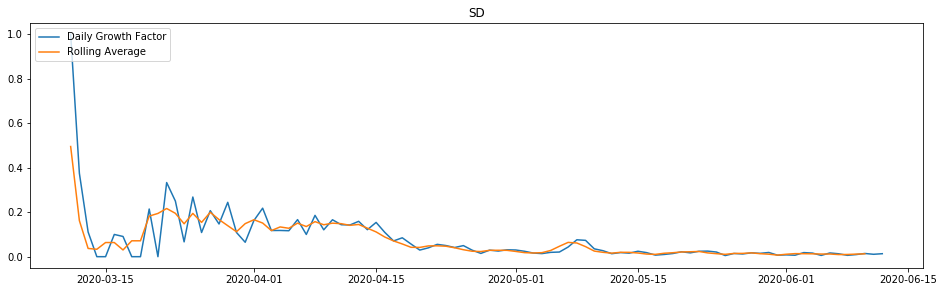

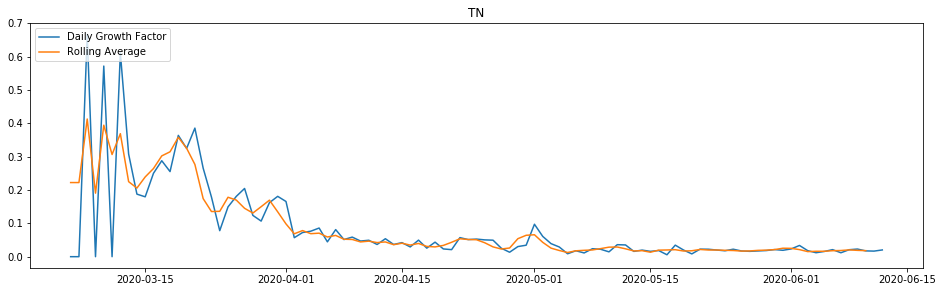

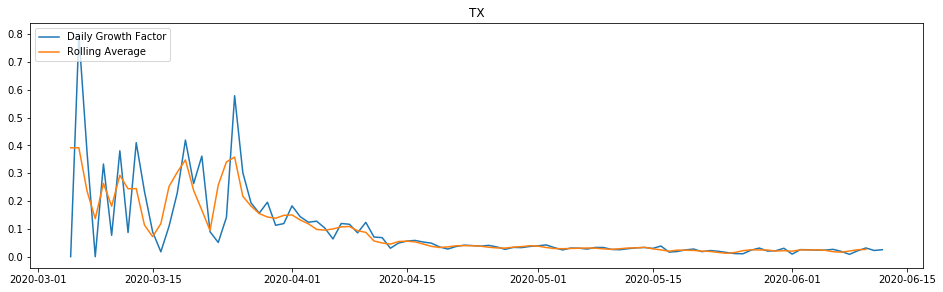

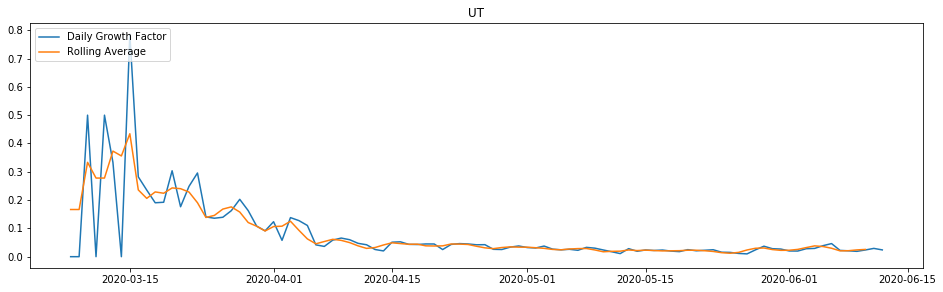

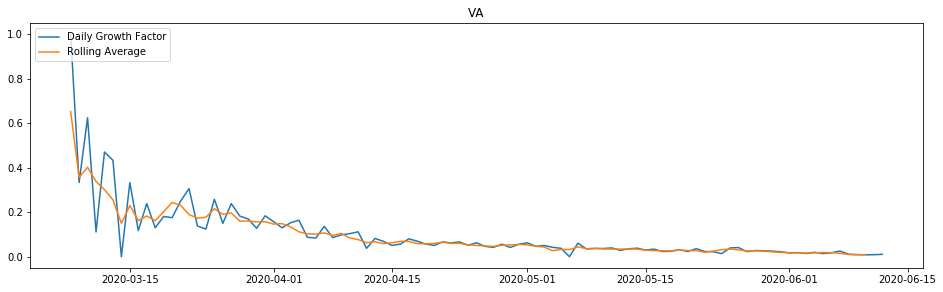

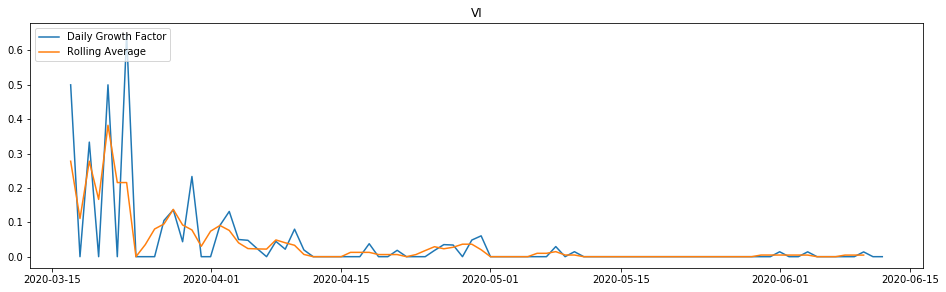

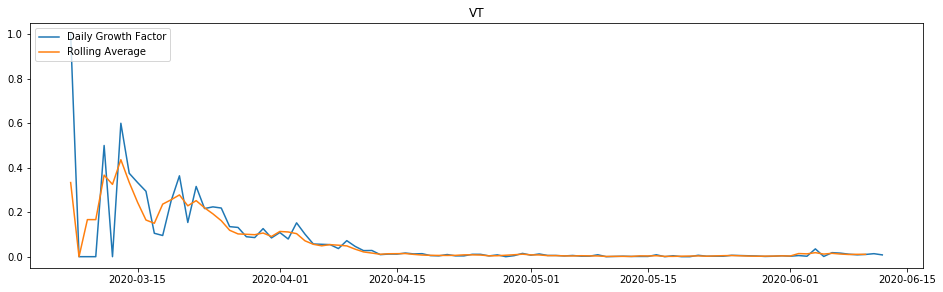

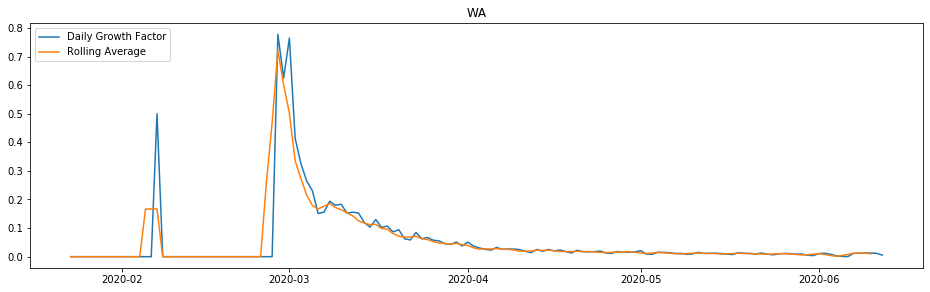

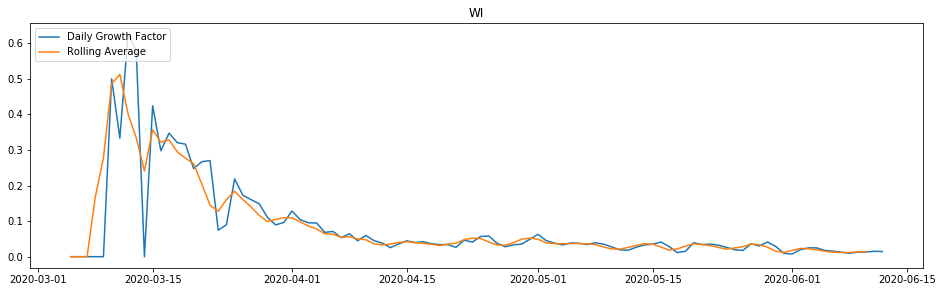

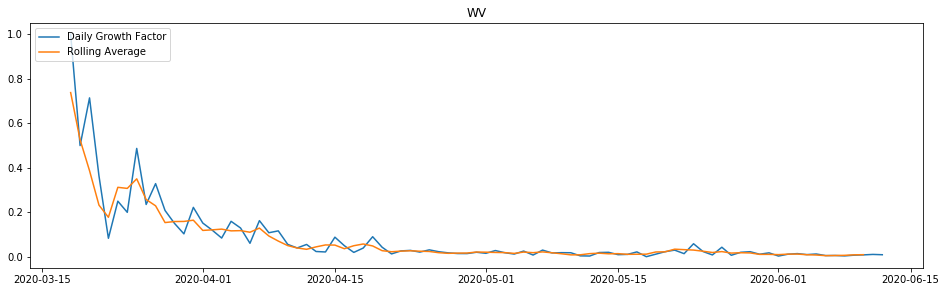

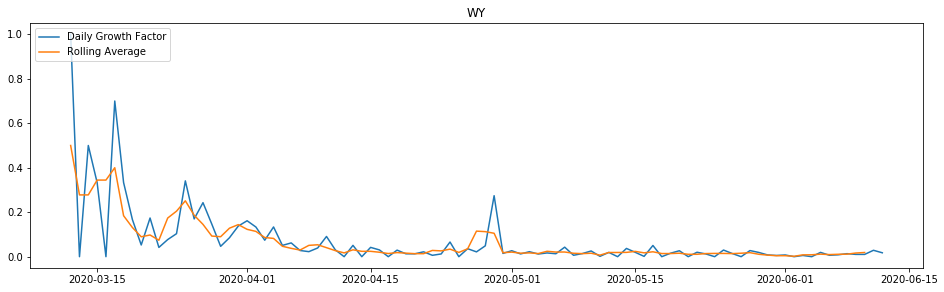

In [25]:
for state in dfs.keys():
    plt.figure(figsize=(16,4.5))
    plt.autoscale(enable=True, axis='y', tight=None)
#    plt.ylim(0,.2)
    plt.plot(dfs[state].index,dfs[state].daily_growth_factor_a, label='Daily Growth Factor')
    plt.plot(dfs[state].index,dfs[state].daily_growth_factor_a.rolling(window=3).mean(), label='Rolling Average')
    plt.legend(loc = 'upper left')
    plt.title(state)

### Daily Growth Factor, ZOOMED IN to Display Small Values: National and State

In [ ]:
for state in dfs.keys():
    plt.figure(figsize=(16,4.5))
    plt.autoscale(enable=True, axis='y', tight=None)
    plt.ylim(0,0.1)
    plt.plot(dfs[state].index,dfs[state].daily_growth_factor, label='Daily Growth Factor')
    plt.plot(dfs[state].index,dfs[state].daily_growth_factor.rolling(window=3).mean(), label='Rolling Average')
    plt.legend(loc = 'upper left')
    plt.title(state)

### Reopening Day by State

In [ ]:
orders = {
  "Alabama" : "April 4 2020",
  "Alaska" : "March 28 2020",
  "Arizona" : "March 31 2020 5 p.m.",
  "Arkansas": None,
  "California" : "March 19",
  "Colorado" : "March 26 2020 6 a.m.",
  "Connecticut" : "March 23 2020 8 p.m.",
  "Delaware" : "March 24 2020 8 a.m.",
  "District of Columbia" : "April 1 2020 12:01 a.m.",
  "Florida" : "April 3 2020 12:01 a.m.",
  "Georgia" : "April 3",
  "Hawaii" : "March 25 2020 12:01 a.m.",
  "Idaho" : "March 25 2020 1:30 p.m.",
  "Illinois" : "March 21 2020 5 p.m.",
  "Indiana" : "March 24 2020 11:59 p.m.",
  "Iowa": None,
  "Kansas" : "March 30 2020 12:01 a.m.",
  "Kentucky" : "March 26 2020 8 p.m.",
  "Louisiana" : "March 23 2020 5 p.m.",
  "Maine" : "April 2 2020 12:01 a.m.",
  "Maryland" : "March 30 2020 8 p.m.",
  "Massachusetts" : "March 24 2020 12 p.m.",
  "Michigan" : "March 24 2020 12:01 a.m.",
  "Minnesota" : "March 27 2020 11:59 p.m.",
  "Mississippi" : "April 3 2020 5 p.m.",
  "Missouri" : "April 6 2020 12:01 a.m.",
  "Montana" : "March 28 2020 12:01 a.m.",
  "Nebraska": None,
  "Nevada" : "April 1",
  "New Hampshire" : "March 27 2020 11:59 p.m.",
  "New Jersey" : "March 21 2020 9 p.m.",
  "New Mexico" : "March 24 2020 8 a.m.",
  "New York" : "March 22 2020 8 p.m.",
  "North Carolina" : "March 30 2020 5 p.m.",
  "North Dakota": None,
  "Ohio" : "March 23 2020 11:59 p.m.",
  "Oklahoma": None,
  "Oregon" : "March 23",
  "Pennsylvania" : "April 1 2020 8 p.m.",
  "Rhode Island" : "March 28",
  "South Carolina" : "April 7 2020 5 p.m.",
  "South Dakota": None,
  "Tennessee" : "March 31 2020 11:59 p.m.",
  "Texas" : "April 2 2020 12:01 a.m.",
  "Utah": None,
  "Vermont" : "March 25 2020 5 p.m.",
  "Virginia" : "March 30",
  "Washington" : "March 23",
  "West Virginia" : "March 24 2020 8 p.m.",
  "Wisconsin" : "March 25 2020 8 a.m.",
  "Wyoming": None,
  "United States" : None
}

In [ ]:
orders_dict = {}
for state in dfs.keys():
    key = state
    value = orders[state]
    orders_dict[key]=value